# Make multiwavelength light curves using archival data
***

## Learning Goals    
By the end of this tutorial, you will be able to:
 - automatically load a catalog of sources
 - automatically search NASA and non-NASA resources for light curves
 - store light curves in a Pandas multiindex dataframe
 - plot all light curves on the same plot
 
 
## Introduction:
 - A user has a sample of interesting targets for which they would like to see a plot of available archival light curves.  We start with a small set of changing look AGN from Yang et al., 2018, which are automatically downloaded. Changing look AGN are cases where the broad emission lines appear or disappear (and not just that the flux is variable). 
 - We model light curve plots after van Velzen et al. 2021.  We search through a curated list of time-domain NASA holdings as well as non-NASA sources.  HEASARC catalogs used are Fermi and Beppo-Sax, IRSA catalogs used are ZTF and WISE, and MAST catalogs used are Pan-Starrs, TESS, Kepler, and K2.  Non-NASA sources are Gaia and IceCube. This list is generalized enough to include many types of targets to make this notebook interesting for many types of science.  All of these time-domain archives are searched in an automated fashion using astroquery or APIs.
 - Light curve data storage is a tricky problem.  Currently we are using a multi-index Pandas dataframe, as the best existing choice for right now.  One downside is that we need to manually track the units of flux and time instead of relying on an astropy storage scheme which would be able to do some of the units worrying for us (even astropy can't do all magnitude to flux conversions).  Astropy does not currently have a good option for multi-band light curve storage.
 - We intend to explore a ML classifier for these changing look AGN light curves.
 
## Input:
 - choose from a list of known changing look AGN from the literature
 
  OR - 
 - input your own sample

## Output:
 - an archival optical + IR + neutrino light curve
 
## Non-standard Imports:
- `astroquery` to interface with archives APIs
- `astropy` to work with coordinates/units and data structures
- `lightkurve` to search TESSS, Kepler, and K2 archives
- `urllib` to handle archive searches with website interface
- `acstools` to work with HST magnitude to flux conversion
- `unTimely` to retrieve WISE light curves
- `alerce` to convert ZTF object names into coordinates

## Authors:
Jessica Krick, Shoubaneh Hemmati, Andreas Faisst, Troy Raen, Brigitta Sipocz, Dave Shupe

## Acknowledgements:
Suvi Gezari, Antara Basu-zych,Stephanie LaMassa\
MAST, HEASARC, & IRSA Fornax teams



In [1]:
#ensure all dependencies are installed
!pip install -r requirements.txt

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import sys
import time
import warnings
from math import ceil
from multiprocessing import Pool

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from scipy import stats

warnings.filterwarnings('ignore')

#get tools for accessing Meisner et al., 2023 WISE light curves
try:
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
except ImportError:
    !pip install git+https://github.com/fkiwy/unTimely_Catalog_explorer
    !pip install reproject
    from unTimely_Catalog_tools import unTimelyCatalogExplorer

# local code imports
sys.path.append('code/')
from panstarrs import panstarrs_get_lightcurves
from gaia_functions import Gaia_get_lightcurve
from HCV_functions import HCV_get_lightcurves
from icecube_functions import icecube_get_lightcurve
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,  get_SDSS_sample, clean_sample
from ztf_functions import ZTF_get_lightcurve
from data_structures import MultiIndexDFObject
from heasarc_functions import HEASARC_get_lightcurves
from TESS_Kepler_functions import TESS_Kepler_get_lightcurves
from WISE_functions import WISE_get_lightcurves

In [3]:
## NEW! LOAD/SAVE PICKLE FILE! ##
SAVEDF = False # if set to True, pickle file will be saved. If False, pickle file will be loaded.
#pickle_file_name = "data/dflc_Shooby_March102023.pkl" # name of pickle file (to be loaded or saved)
pickle_file_name = "data/dflc_Krick_Feb232023.pkl" # name of pickle file (to be loaded or saved)
###

## 1. Define the Sample
 We define here a "gold" sample of spectroscopically confirmed changing look AGN and quasars. This sample includes both objects which change from type 1 to type 2 and also the opposite.  Future studies may want to treat these as seperate objects or seperate QSOs from AGN.
 
 Bibcodes for the samples used are listed next to their functions for reference.  
 
 Functions used to grab the samples from the papers use Astroquery, NED, SIMBAD, Vizier, and in a few cases grab the tables from the html versions of the paper.

In [4]:
#build up the sample
coords =[]
labels = []

#choose your own adventure:

#get_lamassa_sample(coords, labels)  #2015ApJ...800..144L
#get_macleod16_sample(coords, labels) #2016MNRAS.457..389M
#get_ruan_sample(coords, labels) #2016ApJ...826..188R
#get_macleod19_sample(coords, labels)  #2019ApJ...874....8M
#get_sheng_sample(coords, labels)  #2020ApJ...889...46S
#get_green_sample(coords, labels)  #2022ApJ...933..180G
#get_lyu_sample(coords, labels)  #z32022ApJ...927..227L
#get_lopeznavas_sample(coords, labels)  #2022MNRAS.513L..57L
#get_hon_sample(coords, labels)  #2022MNRAS.511...54H
get_yang_sample(coords, labels)   #2018ApJ...862..109Y

#now get some "normal" QSOs for use in the classifier
#there are ~500K of these, so choose the number based on
#a balance between speed of running the light curves and whatever 
#the ML algorithms would like to have

# num_normal_QSO = 100 
#get_SDSS_sample(coords, labels, num_normal_QSO)

# remove duplicates and attach an objectid to the coords
coords_list, labels_list = clean_sample(coords, labels)

#add an index-like list with our own object name
object_names = [['CLAGN' + str(i)] for i in range(len(coords_list))]

## For testing
#coords_list = coords_list[0:4]
#labels_list = labels_list[0:4]
#object_names = object_names[0:4]

Changing Look AGN- Yang et al:  31
after duplicates removal, sample size: 30


### 1.1 Build your own Sample

To build your own sample, you can follow the examples of functions above to grab coordinates from your favorite literature resource, 

or

You can use [astropy's read](https://docs.astropy.org/en/stable/io/ascii/read.html) function to read in an input table
and then convert that table into a list of [skycoords](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) 

## 2. Find light curves for these targets in NASA catalogs
  - We search a curated list of time-domain catalogs from all NASA astrophysics archives


In [5]:
### Initialize Pandas MultiIndex data frame for storing the light curves
df_lc = MultiIndexDFObject()

### 2.1 HEASARC: FERMI & Beppo SAX


In [6]:
start_serial = time.time()
mission_list = ['FERMIGTRIG', 'SAXGRBMGRB']
radius = 0.1*u.degree

#go out and find all light curves in the above curated list which match our target positions
df_lc_heasarc = HEASARC_get_lightcurves(coords_list,labels_list,radius, mission_list)

df_lc.append(df_lc_heasarc)

100%|██████████| 30/30 [00:00<00:00, 53.12it/s]


### 2.2 IRSA: ZTF

In [7]:
df_lc_ZTF = ZTF_get_lightcurve(coords_list,labels_list,plotprint=0) ## number of plots to show to be set by plotprint

#add the resulting dataframe to all other archives
df_lc.append(df_lc_ZTF)

100%|██████████| 30/30 [03:08<00:00,  6.27s/it]

0  objects did not match to ztf


### 2.3 IRSA:WISE

- use the unTimely catalog which ties together all WISE & NEOWISE 2010 - 2020 epochs.  Specifically it combined all observations at a single epoch to achieve deeper mag limits than individual observations alone.
- https://github.com/fkiwy/unTimely_Catalog_explorer
- https://iopscience-iop-org.caltech.idm.oclc.org/article/10.3847/1538-3881/aca2ab

In [8]:
bandlist = ['w1', 'w2']
WISE_radius = 1.0

df_lc_WISE = WISE_get_lightcurves(coords_list, labels_list, WISE_radius, bandlist)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_WISE)

  0%|          | 0/30 [00:00<?, ?it/s]

Scanning catalog index file ...
Scanning individual catalog files ...
./000/0000p000/0000p000_w1_e000.cat.fits.gz
./000/0000p000/0000p000_w2_e000.cat.fits.gz
./000/0000p000/0000p000_w1_e001.cat.fits.gz
./000/0000p000/0000p000_w2_e001.cat.fits.gz
./000/0000p000/0000p000_w1_e002.cat.fits.gz
./000/0000p000/0000p000_w2_e002.cat.fits.gz
./000/0000p000/0000p000_w1_e003.cat.fits.gz
./000/0000p000/0000p000_w2_e003.cat.fits.gz
./000/0000p000/0000p000_w1_e004.cat.fits.gz
./000/0000p000/0000p000_w2_e004.cat.fits.gz
./000/0000p000/0000p000_w1_e005.cat.fits.gz
./000/0000p000/0000p000_w2_e005.cat.fits.gz
./000/0000p000/0000p000_w1_e006.cat.fits.gz
./000/0000p000/0000p000_w2_e006.cat.fits.gz
./000/0000p000/0000p000_w1_e007.cat.fits.gz
./000/0000p000/0000p000_w2_e007.cat.fits.gz
./000/0000p000/0000p000_w1_e008.cat.fits.gz
./000/0000p000/0000p000_w2_e008.cat.fits.gz
./000/0000p000/0000p000_w1_e009.cat.fits.gz
./000/0000p000/0000p000_w2_e009.cat.fits.gz
./000/0000p000/0000p000_w1_e010.cat.fits.gz
./000/

  3%|▎         | 1/30 [00:24<11:54, 24.66s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./021/0214m091/0214m091_w1_e000.cat.fits.gz
./021/0214m091/0214m091_w2_e000.cat.fits.gz
./021/0214m091/0214m091_w1_e001.cat.fits.gz
./021/0214m091/0214m091_w2_e001.cat.fits.gz
./021/0214m091/0214m091_w1_e002.cat.fits.gz
./021/0214m091/0214m091_w2_e002.cat.fits.gz
./021/0214m091/0214m091_w1_e003.cat.fits.gz
./021/0214m091/0214m091_w2_e003.cat.fits.gz
./021/0214m091/0214m091_w1_e004.cat.fits.gz
./021/0214m091/0214m091_w2_e004.cat.fits.gz
./021/0214m091/0214m091_w1_e005.cat.fits.gz
./021/0214m091/0214m091_w2_e005.cat.fits.gz
./021/0214m091/0214m091_w1_e006.cat.fits.gz
./021/0214m091/0214m091_w2_e006.cat.fits.gz
./021/0214m091/0214m091_w1_e007.cat.fits.gz
./021/0214m091/0214m091_w2_e007.cat.fits.gz
./021/0214m091/0214m091_w1_e008.cat.fits.gz
./021/0214m091/0214m091_w2_e008.cat.fits.gz
./021/0214m091/0214m091_w1_e009.cat.fits.gz
./021/0214m091/0214m091_w2_e009.cat.fits.gz
./021/0214m091/0214m091_w1_e010.cat.fits.gz
./021/

  7%|▋         | 2/30 [00:47<11:16, 24.18s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./030/0302p000/0302p000_w1_e000.cat.fits.gz
./030/0302p000/0302p000_w2_e000.cat.fits.gz
./030/0302p000/0302p000_w1_e001.cat.fits.gz
./030/0302p000/0302p000_w2_e001.cat.fits.gz
./030/0302p000/0302p000_w1_e002.cat.fits.gz
./030/0302p000/0302p000_w2_e002.cat.fits.gz
./030/0302p000/0302p000_w1_e003.cat.fits.gz
./030/0302p000/0302p000_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w1_e004.cat.fits.gz
./030/0302p000/0302p000_w2_e004.cat.fits.gz
./030/0302p000/0302p000_w1_e005.cat.fits.gz
./030/0302p000/0302p000_w2_e005.cat.fits.gz
./030/0302p000/0302p000_w1_e006.cat.fits.gz
./030/0302p000/0302p000_w2_e006.cat.fits.gz
./030/0302p000/0302p000_w1_e007.cat.fits.gz
./030/0302p000/0302p000_w2_e007.cat.fits.gz
./030/0302p000/0302p000_w1_e008.cat.fits.gz
./030/0302p000/0302p000_w2_e008.cat.fits.gz
./030/0302p000/0302p000_w1_e009.cat.fits.gz
./030/0302p000/0302p000_w2_e009.cat.fits.gz
./030/0302p000/0302p000_w1_e010.cat.fits.gz
./030/

 10%|█         | 3/30 [01:11<10:47, 23.98s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./121/1213p424/1213p424_w1_e000.cat.fits.gz
./121/1213p424/1213p424_w2_e000.cat.fits.gz
./121/1213p424/1213p424_w1_e001.cat.fits.gz
./121/1213p424/1213p424_w2_e001.cat.fits.gz
./121/1213p424/1213p424_w1_e002.cat.fits.gz
./121/1213p424/1213p424_w2_e002.cat.fits.gz
./121/1213p424/1213p424_w1_e003.cat.fits.gz
./121/1213p424/1213p424_w2_e003.cat.fits.gz
./121/1213p424/1213p424_w1_e004.cat.fits.gz
./121/1213p424/1213p424_w2_e004.cat.fits.gz
./121/1213p424/1213p424_w1_e005.cat.fits.gz
./121/1213p424/1213p424_w2_e005.cat.fits.gz
./121/1213p424/1213p424_w1_e006.cat.fits.gz
./121/1213p424/1213p424_w2_e006.cat.fits.gz
./121/1213p424/1213p424_w1_e007.cat.fits.gz
./121/1213p424/1213p424_w2_e007.cat.fits.gz
./121/1213p424/1213p424_w1_e008.cat.fits.gz
./121/1213p424/1213p424_w2_e008.cat.fits.gz
./121/1213p424/1213p424_w1_e009.cat.fits.gz
./121/1213p424/1213p424_w2_e009.cat.fits.gz
./121/1213p424/1213p424_w1_e010.cat.fits.gz
./121/

 13%|█▎        | 4/30 [01:34<10:21, 23.91s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./128/1287p363/1287p363_w1_e000.cat.fits.gz
./128/1287p363/1287p363_w2_e000.cat.fits.gz
./128/1287p363/1287p363_w1_e001.cat.fits.gz
./128/1287p363/1287p363_w2_e001.cat.fits.gz
./128/1287p363/1287p363_w1_e002.cat.fits.gz
./128/1287p363/1287p363_w2_e002.cat.fits.gz
./128/1287p363/1287p363_w1_e003.cat.fits.gz
./128/1287p363/1287p363_w2_e003.cat.fits.gz
./128/1287p363/1287p363_w1_e004.cat.fits.gz
./128/1287p363/1287p363_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w1_e005.cat.fits.gz
./128/1287p363/1287p363_w2_e005.cat.fits.gz
./128/1287p363/1287p363_w1_e006.cat.fits.gz
./128/1287p363/1287p363_w2_e006.cat.fits.gz
./128/1287p363/1287p363_w1_e007.cat.fits.gz
./128/1287p363/1287p363_w2_e007.cat.fits.gz
./128/1287p363/1287p363_w1_e008.cat.fits.gz
./128/1287p363/1287p363_w2_e008.cat.fits.gz
./128/1287p363/1287p363_w1_e009.cat.fits.gz
./128/1287p363/1287p363_w2_e009.cat.fits.gz
./128/1287p363/1287p363_w1_e010.cat.fits.gz
./128/

 17%|█▋        | 5/30 [01:58<09:54, 23.79s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./131/1318p272/1318p272_w1_e000.cat.fits.gz
./131/1318p272/1318p272_w2_e000.cat.fits.gz
./131/1318p272/1318p272_w1_e001.cat.fits.gz
./131/1318p272/1318p272_w2_e001.cat.fits.gz
./131/1318p272/1318p272_w1_e002.cat.fits.gz
./131/1318p272/1318p272_w2_e002.cat.fits.gz
./131/1318p272/1318p272_w1_e003.cat.fits.gz
./131/1318p272/1318p272_w2_e003.cat.fits.gz
./131/1318p272/1318p272_w1_e004.cat.fits.gz
./131/1318p272/1318p272_w2_e004.cat.fits.gz
./131/1318p272/1318p272_w1_e005.cat.fits.gz
./131/1318p272/1318p272_w2_e005.cat.fits.gz
./131/1318p272/1318p272_w1_e006.cat.fits.gz
./131/1318p272/1318p272_w2_e006.cat.fits.gz
./131/1318p272/1318p272_w1_e007.cat.fits.gz
./131/1318p272/1318p272_w2_e007.cat.fits.gz
./131/1318p272/1318p272_w1_e008.cat.fits.gz
./131/1318p272/1318p272_w2_e008.cat.fits.gz
./131/1318p272/1318p272_w1_e009.cat.fits.gz
./131/1318p272/1318p272_w2_e009.cat.fits.gz
./131/1318p272/1318p272_w1_e010.cat.fits.gz
./131/

 20%|██        | 6/30 [02:22<09:32, 23.85s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./137/1372p484/1372p484_w1_e000.cat.fits.gz
./137/1372p484/1372p484_w2_e000.cat.fits.gz
./137/1372p484/1372p484_w1_e001.cat.fits.gz
./137/1372p484/1372p484_w2_e001.cat.fits.gz
./137/1372p484/1372p484_w1_e002.cat.fits.gz
./137/1372p484/1372p484_w2_e002.cat.fits.gz
./137/1372p484/1372p484_w1_e003.cat.fits.gz
./137/1372p484/1372p484_w2_e003.cat.fits.gz
./137/1372p484/1372p484_w1_e004.cat.fits.gz
./137/1372p484/1372p484_w2_e004.cat.fits.gz
./137/1372p484/1372p484_w1_e005.cat.fits.gz
./137/1372p484/1372p484_w2_e005.cat.fits.gz
./137/1372p484/1372p484_w1_e006.cat.fits.gz
./137/1372p484/1372p484_w2_e006.cat.fits.gz
./137/1372p484/1372p484_w1_e007.cat.fits.gz
./137/1372p484/1372p484_w2_e007.cat.fits.gz
./137/1372p484/1372p484_w1_e008.cat.fits.gz
./137/1372p484/1372p484_w2_e008.cat.fits.gz
./137/1372p484/1372p484_w1_e009.cat.fits.gz
./137/1372p484/1372p484_w2_e009.cat.fits.gz
./137/1372p484/1372p484_w1_e010.cat.fits.gz
./137/

 23%|██▎       | 7/30 [02:46<09:07, 23.79s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./145/1450p257/1450p257_w1_e000.cat.fits.gz
./145/1450p257/1450p257_w2_e000.cat.fits.gz
./145/1450p257/1450p257_w1_e001.cat.fits.gz
./145/1450p257/1450p257_w2_e001.cat.fits.gz
./145/1450p257/1450p257_w1_e002.cat.fits.gz
./145/1450p257/1450p257_w2_e002.cat.fits.gz
./145/1450p257/1450p257_w1_e003.cat.fits.gz
./145/1450p257/1450p257_w2_e003.cat.fits.gz
./145/1450p257/1450p257_w1_e004.cat.fits.gz
./145/1450p257/1450p257_w2_e004.cat.fits.gz
./145/1450p257/1450p257_w1_e005.cat.fits.gz
./145/1450p257/1450p257_w2_e005.cat.fits.gz
./145/1450p257/1450p257_w1_e006.cat.fits.gz
./145/1450p257/1450p257_w2_e006.cat.fits.gz
./145/1450p257/1450p257_w1_e007.cat.fits.gz
./145/1450p257/1450p257_w2_e007.cat.fits.gz
./145/1450p257/1450p257_w1_e008.cat.fits.gz
./145/1450p257/1450p257_w2_e008.cat.fits.gz
./145/1450p257/1450p257_w1_e009.cat.fits.gz
./145/1450p257/1450p257_w2_e009.cat.fits.gz
./145/1450p257/1450p257_w1_e010.cat.fits.gz
./145/

 27%|██▋       | 8/30 [03:09<08:41, 23.69s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./144/1447p318/1447p318_w1_e000.cat.fits.gz
./144/1447p318/1447p318_w2_e000.cat.fits.gz
./144/1447p318/1447p318_w1_e001.cat.fits.gz
./144/1447p318/1447p318_w2_e001.cat.fits.gz
./144/1447p318/1447p318_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e003.cat.fits.gz
./144/1447p318/1447p318_w2_e003.cat.fits.gz
./144/1447p318/1447p318_w1_e004.cat.fits.gz
./144/1447p318/1447p318_w2_e004.cat.fits.gz
./144/1447p318/1447p318_w1_e005.cat.fits.gz
./144/1447p318/1447p318_w2_e005.cat.fits.gz
./144/1447p318/1447p318_w1_e006.cat.fits.gz
./144/1447p318/1447p318_w2_e006.cat.fits.gz
./144/1447p318/1447p318_w1_e007.cat.fits.gz
./144/1447p318/1447p318_w2_e007.cat.fits.gz
./144/1447p318/1447p318_w1_e008.cat.fits.gz
./144/1447p318/1447p318_w2_e008.cat.fits.gz
./144/1447p318/1447p318_w1_e009.cat.fits.gz
./144/1447p318/1447p318_w2_e009.cat.fits.gz
./144/1447p318/1447p318_w1_e010.cat.fits.gz
./144/

 30%|███       | 9/30 [03:33<08:15, 23.61s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./151/1516p348/1516p348_w1_e000.cat.fits.gz
./151/1516p348/1516p348_w2_e000.cat.fits.gz
./151/1516p348/1516p348_w1_e001.cat.fits.gz
./151/1516p348/1516p348_w2_e001.cat.fits.gz
./151/1516p348/1516p348_w1_e002.cat.fits.gz
./151/1516p348/1516p348_w2_e002.cat.fits.gz
./151/1516p348/1516p348_w1_e003.cat.fits.gz
./151/1516p348/1516p348_w2_e003.cat.fits.gz
./151/1516p348/1516p348_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w2_e004.cat.fits.gz
./151/1516p348/1516p348_w1_e005.cat.fits.gz
./151/1516p348/1516p348_w2_e005.cat.fits.gz
./151/1516p348/1516p348_w1_e006.cat.fits.gz
./151/1516p348/1516p348_w2_e006.cat.fits.gz
./151/1516p348/1516p348_w1_e007.cat.fits.gz
./151/1516p348/1516p348_w2_e007.cat.fits.gz
./151/1516p348/1516p348_w1_e008.cat.fits.gz
./151/1516p348/1516p348_w2_e008.cat.fits.gz
./151/1516p348/1516p348_w1_e009.cat.fits.gz
./151/1516p348/1516p348_w2_e009.cat.fits.gz
./151/1516p348/1516p348_w1_e010.cat.fits.gz
./151/

 33%|███▎      | 10/30 [03:56<07:53, 23.65s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./153/1531p545/1531p545_w1_e000.cat.fits.gz
./153/1531p545/1531p545_w2_e000.cat.fits.gz
./153/1531p545/1531p545_w1_e001.cat.fits.gz
./153/1531p545/1531p545_w2_e001.cat.fits.gz
./153/1531p545/1531p545_w1_e002.cat.fits.gz
./153/1531p545/1531p545_w2_e002.cat.fits.gz
./153/1531p545/1531p545_w1_e003.cat.fits.gz
./153/1531p545/1531p545_w2_e003.cat.fits.gz
./153/1531p545/1531p545_w1_e004.cat.fits.gz
./153/1531p545/1531p545_w2_e004.cat.fits.gz
./153/1531p545/1531p545_w1_e005.cat.fits.gz
./153/1531p545/1531p545_w2_e005.cat.fits.gz
./153/1531p545/1531p545_w1_e006.cat.fits.gz
./153/1531p545/1531p545_w2_e006.cat.fits.gz
./153/1531p545/1531p545_w1_e007.cat.fits.gz
./153/1531p545/1531p545_w2_e007.cat.fits.gz
./153/1531p545/1531p545_w1_e008.cat.fits.gz
./153/1531p545/1531p545_w2_e008.cat.fits.gz
./153/1531p545/1531p545_w1_e009.cat.fits.gz
./153/1531p545/1531p545_w2_e009.cat.fits.gz
./153/1531p545/1531p545_w1_e010.cat.fits.gz
./153/

 37%|███▋      | 11/30 [04:20<07:31, 23.78s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./165/1651p636/1651p636_w1_e000.cat.fits.gz
./165/1651p636/1651p636_w2_e000.cat.fits.gz
./165/1651p636/1651p636_w1_e001.cat.fits.gz
./165/1651p636/1651p636_w2_e001.cat.fits.gz
./165/1651p636/1651p636_w1_e002.cat.fits.gz
./165/1651p636/1651p636_w2_e002.cat.fits.gz
./165/1651p636/1651p636_w1_e003.cat.fits.gz
./165/1651p636/1651p636_w2_e003.cat.fits.gz
./165/1651p636/1651p636_w1_e004.cat.fits.gz
./165/1651p636/1651p636_w2_e004.cat.fits.gz
./165/1651p636/1651p636_w1_e005.cat.fits.gz
./165/1651p636/1651p636_w2_e005.cat.fits.gz
./165/1651p636/1651p636_w1_e006.cat.fits.gz
./165/1651p636/1651p636_w2_e006.cat.fits.gz
./165/1651p636/1651p636_w1_e007.cat.fits.gz
./165/1651p636/1651p636_w2_e007.cat.fits.gz
./165/1651p636/1651p636_w1_e008.cat.fits.gz
./165/1651p636/1651p636_w2_e008.cat.fits.gz
./165/1651p636/1651p636_w1_e009.cat.fits.gz
./165/1651p636/1651p636_w2_e009.cat.fits.gz
./165/1651p636/1651p636_w1_e010.cat.fits.gz
./165/

 40%|████      | 12/30 [04:47<07:20, 24.50s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./166/1663p015/1663p015_w1_e000.cat.fits.gz
./166/1663p015/1663p015_w2_e000.cat.fits.gz
./166/1663p015/1663p015_w1_e001.cat.fits.gz
./166/1663p015/1663p015_w2_e001.cat.fits.gz
./166/1663p015/1663p015_w1_e002.cat.fits.gz
./166/1663p015/1663p015_w2_e002.cat.fits.gz
./166/1663p015/1663p015_w1_e003.cat.fits.gz
./166/1663p015/1663p015_w2_e003.cat.fits.gz
./166/1663p015/1663p015_w1_e004.cat.fits.gz
./166/1663p015/1663p015_w2_e004.cat.fits.gz
./166/1663p015/1663p015_w1_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w2_e006.cat.fits.gz
./166/1663p015/1663p015_w1_e007.cat.fits.gz
./166/1663p015/1663p015_w2_e007.cat.fits.gz
./166/1663p015/1663p015_w1_e008.cat.fits.gz
./166/1663p015/1663p015_w2_e008.cat.fits.gz
./166/1663p015/1663p015_w1_e009.cat.fits.gz
./166/1663p015/1663p015_w2_e009.cat.fits.gz
./166/1663p015/1663p015_w1_e010.cat.fits.gz
./166/

 43%|████▎     | 13/30 [05:09<06:46, 23.93s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./167/1678p000/1678p000_w1_e000.cat.fits.gz
./167/1678p000/1678p000_w2_e000.cat.fits.gz
./167/1678p000/1678p000_w1_e001.cat.fits.gz
./167/1678p000/1678p000_w2_e001.cat.fits.gz
./167/1678p000/1678p000_w1_e002.cat.fits.gz
./167/1678p000/1678p000_w2_e002.cat.fits.gz
./167/1678p000/1678p000_w1_e003.cat.fits.gz
./167/1678p000/1678p000_w2_e003.cat.fits.gz
./167/1678p000/1678p000_w1_e004.cat.fits.gz
./167/1678p000/1678p000_w2_e004.cat.fits.gz
./167/1678p000/1678p000_w1_e005.cat.fits.gz
./167/1678p000/1678p000_w2_e005.cat.fits.gz
./167/1678p000/1678p000_w1_e006.cat.fits.gz
./167/1678p000/1678p000_w2_e006.cat.fits.gz
./167/1678p000/1678p000_w1_e007.cat.fits.gz
./167/1678p000/1678p000_w2_e007.cat.fits.gz
./167/1678p000/1678p000_w1_e008.cat.fits.gz
./167/1678p000/1678p000_w2_e008.cat.fits.gz
./167/1678p000/1678p000_w1_e009.cat.fits.gz
./167/1678p000/1678p000_w2_e009.cat.fits.gz
./167/1678p000/1678p000_w1_e010.cat.fits.gz
./167/

 47%|████▋     | 14/30 [05:32<06:17, 23.58s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./168/1686p060/1686p060_w1_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e000.cat.fits.gz
./168/1686p060/1686p060_w1_e001.cat.fits.gz
./168/1686p060/1686p060_w2_e001.cat.fits.gz
./168/1686p060/1686p060_w1_e002.cat.fits.gz
./168/1686p060/1686p060_w2_e002.cat.fits.gz
./168/1686p060/1686p060_w1_e003.cat.fits.gz
./168/1686p060/1686p060_w2_e003.cat.fits.gz
./168/1686p060/1686p060_w1_e004.cat.fits.gz
./168/1686p060/1686p060_w2_e004.cat.fits.gz
./168/1686p060/1686p060_w1_e005.cat.fits.gz
./168/1686p060/1686p060_w2_e005.cat.fits.gz
./168/1686p060/1686p060_w1_e006.cat.fits.gz
./168/1686p060/1686p060_w2_e006.cat.fits.gz
./168/1686p060/1686p060_w1_e007.cat.fits.gz
./168/1686p060/1686p060_w2_e007.cat.fits.gz
./168/1686p060/1686p060_w1_e008.cat.fits.gz
./168/1686p060/1686p060_w2_e008.cat.fits.gz
./168/1686p060/1686p060_w1_e009.cat.fits.gz
./168/1686p060/1686p060_w2_e009.cat.fits.gz
./168/1686p060/1686p060_w1_e010.cat.fits.gz
./168/

 50%|█████     | 15/30 [05:55<05:49, 23.32s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./169/1694p318/1694p318_w1_e000.cat.fits.gz
./169/1694p318/1694p318_w2_e000.cat.fits.gz
./169/1694p318/1694p318_w1_e001.cat.fits.gz
./169/1694p318/1694p318_w2_e001.cat.fits.gz
./169/1694p318/1694p318_w1_e002.cat.fits.gz
./169/1694p318/1694p318_w2_e002.cat.fits.gz
./169/1694p318/1694p318_w1_e003.cat.fits.gz
./169/1694p318/1694p318_w2_e003.cat.fits.gz
./169/1694p318/1694p318_w1_e004.cat.fits.gz
./169/1694p318/1694p318_w2_e004.cat.fits.gz
./169/1694p318/1694p318_w1_e005.cat.fits.gz
./169/1694p318/1694p318_w2_e005.cat.fits.gz
./169/1694p318/1694p318_w1_e006.cat.fits.gz
./169/1694p318/1694p318_w2_e006.cat.fits.gz
./169/1694p318/1694p318_w1_e007.cat.fits.gz
./169/1694p318/1694p318_w2_e007.cat.fits.gz
./169/1694p318/1694p318_w1_e008.cat.fits.gz
./169/1694p318/1694p318_w2_e008.cat.fits.gz
./169/1694p318/1694p318_w1_e009.cat.fits.gz
./169/1694p318/1694p318_w2_e009.cat.fits.gz
./169/1694p318/1694p318_w1_e010.cat.fits.gz
./169/

 53%|█████▎    | 16/30 [06:18<05:24, 23.21s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./173/1731p045/1731p045_w1_e000.cat.fits.gz
./173/1731p045/1731p045_w2_e000.cat.fits.gz
./173/1731p045/1731p045_w1_e001.cat.fits.gz
./173/1731p045/1731p045_w2_e001.cat.fits.gz
./173/1731p045/1731p045_w1_e002.cat.fits.gz
./173/1731p045/1731p045_w2_e002.cat.fits.gz
./173/1731p045/1731p045_w1_e003.cat.fits.gz
./173/1731p045/1731p045_w2_e003.cat.fits.gz
./173/1731p045/1731p045_w1_e004.cat.fits.gz
./173/1731p045/1731p045_w2_e004.cat.fits.gz
./173/1731p045/1731p045_w1_e005.cat.fits.gz
./173/1731p045/1731p045_w2_e005.cat.fits.gz
./173/1731p045/1731p045_w1_e006.cat.fits.gz
./173/1731p045/1731p045_w2_e006.cat.fits.gz
./173/1731p045/1731p045_w1_e007.cat.fits.gz
./173/1731p045/1731p045_w2_e007.cat.fits.gz
./173/1731p045/1731p045_w1_e008.cat.fits.gz
./173/1731p045/1731p045_w2_e008.cat.fits.gz
./173/1731p045/1731p045_w1_e009.cat.fits.gz
./173/1731p045/1731p045_w2_e009.cat.fits.gz
./173/1731p045/1731p045_w1_e010.cat.fits.gz
./173/

 57%|█████▋    | 17/30 [06:40<04:59, 23.04s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./177/1772p363/1772p363_w1_e000.cat.fits.gz
./177/1772p363/1772p363_w2_e000.cat.fits.gz
./177/1772p363/1772p363_w1_e001.cat.fits.gz
./177/1772p363/1772p363_w2_e001.cat.fits.gz
./177/1772p363/1772p363_w1_e002.cat.fits.gz
./177/1772p363/1772p363_w2_e002.cat.fits.gz
./177/1772p363/1772p363_w1_e003.cat.fits.gz
./177/1772p363/1772p363_w2_e003.cat.fits.gz
./177/1772p363/1772p363_w1_e004.cat.fits.gz
./177/1772p363/1772p363_w2_e004.cat.fits.gz
./177/1772p363/1772p363_w1_e005.cat.fits.gz
./177/1772p363/1772p363_w2_e005.cat.fits.gz
./177/1772p363/1772p363_w1_e006.cat.fits.gz
./177/1772p363/1772p363_w2_e006.cat.fits.gz
./177/1772p363/1772p363_w1_e007.cat.fits.gz
./177/1772p363/1772p363_w2_e007.cat.fits.gz
./177/1772p363/1772p363_w1_e008.cat.fits.gz
./177/1772p363/1772p363_w2_e008.cat.fits.gz
./177/1772p363/1772p363_w1_e009.cat.fits.gz
./177/1772p363/1772p363_w2_e009.cat.fits.gz
./177/1772p363/1772p363_w1_e010.cat.fits.gz
./177/

 60%|██████    | 18/30 [07:04<04:39, 23.27s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./178/1782p318/1782p318_w1_e000.cat.fits.gz
./178/1782p318/1782p318_w2_e000.cat.fits.gz
./178/1782p318/1782p318_w1_e001.cat.fits.gz
./178/1782p318/1782p318_w2_e001.cat.fits.gz
./178/1782p318/1782p318_w1_e002.cat.fits.gz
./178/1782p318/1782p318_w2_e002.cat.fits.gz
./178/1782p318/1782p318_w1_e003.cat.fits.gz
./178/1782p318/1782p318_w2_e003.cat.fits.gz
./178/1782p318/1782p318_w1_e004.cat.fits.gz
./178/1782p318/1782p318_w2_e004.cat.fits.gz
./178/1782p318/1782p318_w1_e005.cat.fits.gz
./178/1782p318/1782p318_w2_e005.cat.fits.gz
./178/1782p318/1782p318_w1_e006.cat.fits.gz
./178/1782p318/1782p318_w2_e006.cat.fits.gz
./178/1782p318/1782p318_w1_e007.cat.fits.gz
./178/1782p318/1782p318_w2_e007.cat.fits.gz
./178/1782p318/1782p318_w1_e008.cat.fits.gz
./178/1782p318/1782p318_w2_e008.cat.fits.gz
./178/1782p318/1782p318_w1_e009.cat.fits.gz
./178/1782p318/1782p318_w2_e009.cat.fits.gz
./178/1782p318/1782p318_w1_e010.cat.fits.gz
./178/

 63%|██████▎   | 19/30 [07:27<04:16, 23.33s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./194/1940p545/1940p545_w1_e000.cat.fits.gz
./194/1940p545/1940p545_w2_e000.cat.fits.gz
./194/1940p545/1940p545_w1_e001.cat.fits.gz
./194/1940p545/1940p545_w2_e001.cat.fits.gz
./194/1940p545/1940p545_w1_e002.cat.fits.gz
./194/1940p545/1940p545_w2_e002.cat.fits.gz
./194/1940p545/1940p545_w1_e003.cat.fits.gz
./194/1940p545/1940p545_w2_e003.cat.fits.gz
./194/1940p545/1940p545_w1_e004.cat.fits.gz
./194/1940p545/1940p545_w2_e004.cat.fits.gz
./194/1940p545/1940p545_w1_e005.cat.fits.gz
./194/1940p545/1940p545_w2_e005.cat.fits.gz
./194/1940p545/1940p545_w1_e006.cat.fits.gz
./194/1940p545/1940p545_w2_e006.cat.fits.gz
./194/1940p545/1940p545_w1_e007.cat.fits.gz
./194/1940p545/1940p545_w2_e007.cat.fits.gz
./194/1940p545/1940p545_w1_e008.cat.fits.gz
./194/1940p545/1940p545_w2_e008.cat.fits.gz
./194/1940p545/1940p545_w1_e009.cat.fits.gz
./194/1940p545/1940p545_w2_e009.cat.fits.gz
./194/1940p545/1940p545_w1_e010.cat.fits.gz
./194/

 67%|██████▋   | 20/30 [07:53<03:58, 23.89s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./201/2017p681/2017p681_w1_e000.cat.fits.gz
./201/2017p681/2017p681_w2_e000.cat.fits.gz
./201/2017p681/2017p681_w1_e001.cat.fits.gz
./201/2017p681/2017p681_w2_e001.cat.fits.gz
./201/2017p681/2017p681_w1_e002.cat.fits.gz
./201/2017p681/2017p681_w2_e002.cat.fits.gz
./201/2017p681/2017p681_w1_e003.cat.fits.gz
./201/2017p681/2017p681_w2_e003.cat.fits.gz
./201/2017p681/2017p681_w1_e004.cat.fits.gz
./201/2017p681/2017p681_w2_e004.cat.fits.gz
./201/2017p681/2017p681_w1_e005.cat.fits.gz
./201/2017p681/2017p681_w2_e005.cat.fits.gz
./201/2017p681/2017p681_w1_e006.cat.fits.gz
./201/2017p681/2017p681_w2_e006.cat.fits.gz
./201/2017p681/2017p681_w1_e007.cat.fits.gz
./201/2017p681/2017p681_w2_e007.cat.fits.gz
./201/2017p681/2017p681_w1_e008.cat.fits.gz
./201/2017p681/2017p681_w2_e008.cat.fits.gz
./201/2017p681/2017p681_w1_e009.cat.fits.gz
./201/2017p681/2017p681_w2_e009.cat.fits.gz
./201/2017p681/2017p681_w1_e010.cat.fits.gz
./201/

 70%|███████   | 21/30 [08:20<03:44, 24.97s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./208/2087m016/2087m016_w1_e000.cat.fits.gz
./208/2087m016/2087m016_w2_e000.cat.fits.gz
./208/2087m016/2087m016_w1_e001.cat.fits.gz
./208/2087m016/2087m016_w2_e001.cat.fits.gz
./208/2087m016/2087m016_w1_e002.cat.fits.gz
./208/2087m016/2087m016_w2_e002.cat.fits.gz
./208/2087m016/2087m016_w1_e003.cat.fits.gz
./208/2087m016/2087m016_w2_e003.cat.fits.gz
./208/2087m016/2087m016_w1_e004.cat.fits.gz
./208/2087m016/2087m016_w2_e004.cat.fits.gz
./208/2087m016/2087m016_w1_e005.cat.fits.gz
./208/2087m016/2087m016_w2_e005.cat.fits.gz
./208/2087m016/2087m016_w1_e006.cat.fits.gz
./208/2087m016/2087m016_w2_e006.cat.fits.gz
./208/2087m016/2087m016_w1_e007.cat.fits.gz
./208/2087m016/2087m016_w2_e007.cat.fits.gz
./208/2087m016/2087m016_w1_e008.cat.fits.gz
./208/2087m016/2087m016_w2_e008.cat.fits.gz
./208/2087m016/2087m016_w1_e009.cat.fits.gz
./208/2087m016/2087m016_w2_e009.cat.fits.gz
./208/2087m016/2087m016_w1_e010.cat.fits.gz
./208/

 73%|███████▎  | 22/30 [08:45<03:18, 24.85s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./209/2090p499/2090p499_w1_e000.cat.fits.gz
./209/2090p499/2090p499_w2_e000.cat.fits.gz
./209/2090p499/2090p499_w1_e001.cat.fits.gz
./209/2090p499/2090p499_w2_e001.cat.fits.gz
./209/2090p499/2090p499_w1_e002.cat.fits.gz
./209/2090p499/2090p499_w2_e002.cat.fits.gz
./209/2090p499/2090p499_w1_e003.cat.fits.gz
./209/2090p499/2090p499_w2_e003.cat.fits.gz
./209/2090p499/2090p499_w1_e004.cat.fits.gz
./209/2090p499/2090p499_w2_e004.cat.fits.gz
./209/2090p499/2090p499_w1_e005.cat.fits.gz
./209/2090p499/2090p499_w2_e005.cat.fits.gz
./209/2090p499/2090p499_w1_e006.cat.fits.gz
./209/2090p499/2090p499_w2_e006.cat.fits.gz
./209/2090p499/2090p499_w1_e007.cat.fits.gz
./209/2090p499/2090p499_w2_e007.cat.fits.gz
./209/2090p499/2090p499_w1_e008.cat.fits.gz
./209/2090p499/2090p499_w2_e008.cat.fits.gz
./209/2090p499/2090p499_w1_e009.cat.fits.gz
./209/2090p499/2090p499_w2_e009.cat.fits.gz
./209/2090p499/2090p499_w1_e010.cat.fits.gz
./209/

 77%|███████▋  | 23/30 [09:11<02:56, 25.24s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./221/2211p287/2211p287_w1_e000.cat.fits.gz
./221/2211p287/2211p287_w2_e000.cat.fits.gz
./221/2211p287/2211p287_w1_e001.cat.fits.gz
./221/2211p287/2211p287_w2_e001.cat.fits.gz
./221/2211p287/2211p287_w1_e002.cat.fits.gz
./221/2211p287/2211p287_w2_e002.cat.fits.gz
./221/2211p287/2211p287_w1_e003.cat.fits.gz
./221/2211p287/2211p287_w2_e003.cat.fits.gz
./221/2211p287/2211p287_w1_e004.cat.fits.gz
./221/2211p287/2211p287_w2_e004.cat.fits.gz
./221/2211p287/2211p287_w1_e005.cat.fits.gz
./221/2211p287/2211p287_w2_e005.cat.fits.gz
./221/2211p287/2211p287_w1_e006.cat.fits.gz
./221/2211p287/2211p287_w2_e006.cat.fits.gz
./221/2211p287/2211p287_w1_e007.cat.fits.gz
./221/2211p287/2211p287_w2_e007.cat.fits.gz
./221/2211p287/2211p287_w1_e008.cat.fits.gz
./221/2211p287/2211p287_w2_e008.cat.fits.gz
./221/2211p287/2211p287_w1_e009.cat.fits.gz
./221/2211p287/2211p287_w2_e009.cat.fits.gz
./221/2211p287/2211p287_w1_e010.cat.fits.gz
./221/

 80%|████████  | 24/30 [09:37<02:32, 25.42s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./232/2329p015/2329p015_w1_e000.cat.fits.gz
./232/2329p015/2329p015_w2_e000.cat.fits.gz
./232/2329p015/2329p015_w1_e001.cat.fits.gz
./232/2329p015/2329p015_w2_e001.cat.fits.gz
./232/2329p015/2329p015_w1_e002.cat.fits.gz
./232/2329p015/2329p015_w2_e002.cat.fits.gz
./232/2329p015/2329p015_w1_e003.cat.fits.gz
./232/2329p015/2329p015_w2_e003.cat.fits.gz
./232/2329p015/2329p015_w1_e004.cat.fits.gz
./232/2329p015/2329p015_w2_e004.cat.fits.gz
./232/2329p015/2329p015_w1_e005.cat.fits.gz
./232/2329p015/2329p015_w2_e005.cat.fits.gz
./232/2329p015/2329p015_w1_e006.cat.fits.gz
./232/2329p015/2329p015_w2_e006.cat.fits.gz
./232/2329p015/2329p015_w1_e007.cat.fits.gz
./232/2329p015/2329p015_w2_e007.cat.fits.gz
./232/2329p015/2329p015_w1_e008.cat.fits.gz
./232/2329p015/2329p015_w2_e008.cat.fits.gz
./232/2329p015/2329p015_w1_e009.cat.fits.gz
./232/2329p015/2329p015_w2_e009.cat.fits.gz
./232/2329p015/2329p015_w1_e010.cat.fits.gz
./232/

 83%|████████▎ | 25/30 [10:02<02:06, 25.37s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./236/2366p257/2366p257_w1_e000.cat.fits.gz
./236/2366p257/2366p257_w2_e000.cat.fits.gz
./236/2366p257/2366p257_w1_e001.cat.fits.gz
./236/2366p257/2366p257_w2_e001.cat.fits.gz
./236/2366p257/2366p257_w1_e002.cat.fits.gz
./236/2366p257/2366p257_w2_e002.cat.fits.gz
./236/2366p257/2366p257_w1_e003.cat.fits.gz
./236/2366p257/2366p257_w2_e003.cat.fits.gz
./236/2366p257/2366p257_w1_e004.cat.fits.gz
./236/2366p257/2366p257_w2_e004.cat.fits.gz
./236/2366p257/2366p257_w1_e005.cat.fits.gz
./236/2366p257/2366p257_w2_e005.cat.fits.gz
./236/2366p257/2366p257_w1_e006.cat.fits.gz
./236/2366p257/2366p257_w2_e006.cat.fits.gz
./236/2366p257/2366p257_w1_e007.cat.fits.gz
./236/2366p257/2366p257_w2_e007.cat.fits.gz
./236/2366p257/2366p257_w1_e008.cat.fits.gz
./236/2366p257/2366p257_w2_e008.cat.fits.gz
./236/2366p257/2366p257_w1_e009.cat.fits.gz
./236/2366p257/2366p257_w2_e009.cat.fits.gz
./236/2366p257/2366p257_w1_e010.cat.fits.gz
./236/

 87%|████████▋ | 26/30 [10:28<01:41, 25.46s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./237/2373p408/2373p408_w1_e000.cat.fits.gz
./237/2373p408/2373p408_w2_e000.cat.fits.gz
./237/2373p408/2373p408_w1_e001.cat.fits.gz
./237/2373p408/2373p408_w2_e001.cat.fits.gz
./237/2373p408/2373p408_w1_e002.cat.fits.gz
./237/2373p408/2373p408_w2_e002.cat.fits.gz
./237/2373p408/2373p408_w1_e003.cat.fits.gz
./237/2373p408/2373p408_w2_e003.cat.fits.gz
./237/2373p408/2373p408_w1_e004.cat.fits.gz
./237/2373p408/2373p408_w2_e004.cat.fits.gz
./237/2373p408/2373p408_w1_e005.cat.fits.gz
./237/2373p408/2373p408_w2_e005.cat.fits.gz
./237/2373p408/2373p408_w1_e006.cat.fits.gz
./237/2373p408/2373p408_w2_e006.cat.fits.gz
./237/2373p408/2373p408_w1_e007.cat.fits.gz
./237/2373p408/2373p408_w2_e007.cat.fits.gz
./237/2373p408/2373p408_w1_e008.cat.fits.gz
./237/2373p408/2373p408_w2_e008.cat.fits.gz
./237/2373p408/2373p408_w1_e009.cat.fits.gz
./237/2373p408/2373p408_w2_e009.cat.fits.gz
./237/2373p408/2373p408_w1_e010.cat.fits.gz
./237/

 90%|█████████ | 27/30 [10:56<01:18, 26.33s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./238/2383p272/2383p272_w1_e000.cat.fits.gz
./238/2383p272/2383p272_w2_e000.cat.fits.gz
./238/2383p272/2383p272_w1_e001.cat.fits.gz
./238/2383p272/2383p272_w2_e001.cat.fits.gz
./238/2383p272/2383p272_w1_e002.cat.fits.gz
./238/2383p272/2383p272_w2_e002.cat.fits.gz
./238/2383p272/2383p272_w1_e003.cat.fits.gz
./238/2383p272/2383p272_w2_e003.cat.fits.gz
./238/2383p272/2383p272_w1_e004.cat.fits.gz
./238/2383p272/2383p272_w2_e004.cat.fits.gz
./238/2383p272/2383p272_w1_e005.cat.fits.gz
./238/2383p272/2383p272_w2_e005.cat.fits.gz
./238/2383p272/2383p272_w1_e006.cat.fits.gz
./238/2383p272/2383p272_w2_e006.cat.fits.gz
./238/2383p272/2383p272_w1_e007.cat.fits.gz
./238/2383p272/2383p272_w2_e007.cat.fits.gz
./238/2383p272/2383p272_w1_e008.cat.fits.gz
./238/2383p272/2383p272_w2_e008.cat.fits.gz
./238/2383p272/2383p272_w1_e009.cat.fits.gz
./238/2383p272/2383p272_w2_e009.cat.fits.gz
./238/2383p272/2383p272_w1_e010.cat.fits.gz
./238/

 93%|█████████▎| 28/30 [11:22<00:52, 26.34s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./238/2387p363/2387p363_w1_e000.cat.fits.gz
./238/2387p363/2387p363_w2_e000.cat.fits.gz
./238/2387p363/2387p363_w1_e001.cat.fits.gz
./238/2387p363/2387p363_w2_e001.cat.fits.gz
./238/2387p363/2387p363_w1_e002.cat.fits.gz
./238/2387p363/2387p363_w2_e002.cat.fits.gz
./238/2387p363/2387p363_w1_e003.cat.fits.gz
./238/2387p363/2387p363_w2_e003.cat.fits.gz
./238/2387p363/2387p363_w1_e004.cat.fits.gz
./238/2387p363/2387p363_w2_e004.cat.fits.gz
./238/2387p363/2387p363_w1_e005.cat.fits.gz
./238/2387p363/2387p363_w2_e005.cat.fits.gz
./238/2387p363/2387p363_w1_e006.cat.fits.gz
./238/2387p363/2387p363_w2_e006.cat.fits.gz
./238/2387p363/2387p363_w1_e007.cat.fits.gz
./238/2387p363/2387p363_w2_e007.cat.fits.gz
./238/2387p363/2387p363_w1_e008.cat.fits.gz
./238/2387p363/2387p363_w2_e008.cat.fits.gz
./238/2387p363/2387p363_w1_e009.cat.fits.gz
./238/2387p363/2387p363_w2_e009.cat.fits.gz
./238/2387p363/2387p363_w1_e010.cat.fits.gz
./238/

 97%|█████████▋| 29/30 [11:50<00:26, 26.60s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./353/3539p000/3539p000_w1_e000.cat.fits.gz
./353/3539p000/3539p000_w2_e000.cat.fits.gz
./353/3539p000/3539p000_w1_e001.cat.fits.gz
./353/3539p000/3539p000_w2_e001.cat.fits.gz
./353/3539p000/3539p000_w1_e002.cat.fits.gz
./353/3539p000/3539p000_w2_e002.cat.fits.gz
./353/3539p000/3539p000_w1_e003.cat.fits.gz
./353/3539p000/3539p000_w2_e003.cat.fits.gz
./353/3539p000/3539p000_w1_e004.cat.fits.gz
./353/3539p000/3539p000_w2_e004.cat.fits.gz
./353/3539p000/3539p000_w1_e005.cat.fits.gz
./353/3539p000/3539p000_w2_e005.cat.fits.gz
./353/3539p000/3539p000_w1_e006.cat.fits.gz
./353/3539p000/3539p000_w2_e006.cat.fits.gz
./353/3539p000/3539p000_w1_e007.cat.fits.gz
./353/3539p000/3539p000_w2_e007.cat.fits.gz
./353/3539p000/3539p000_w1_e008.cat.fits.gz
./353/3539p000/3539p000_w2_e008.cat.fits.gz
./353/3539p000/3539p000_w1_e009.cat.fits.gz
./353/3539p000/3539p000_w2_e009.cat.fits.gz
./353/3539p000/3539p000_w1_e010.cat.fits.gz
./353/

100%|██████████| 30/30 [12:13<00:00, 24.44s/it]


### 2.4 MAST: Pan-STARRS
Query the Pan-STARRS API; based on this [example](https://ps1images.stsci.edu/ps1_dr2_api.html)

In [9]:
#Do a panstarrs search
panstarrs_radius = 1.0/3600.0    # search radius = 1 arcsec
df_lc_panstarrs = panstarrs_get_lightcurves(coords_list, labels_list, panstarrs_radius)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_panstarrs)

100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


### 2.5 MAST: Asteroid Terrestrial-impact Last Alert System (ATLAS)
 - All-sky stellar reference catalog 
 -  MAST hosts this catalog but there are three barriers to using it
     1. it is unclear if the MAST [holdings]( https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1) include the individual epoch photometry and 
     2. it is only accessible with casjobs, not through python notebooks.  
     3. magnitude range (g, r, i) < 19mag makes it not relevant for this use case
 
One path forward if this catalog becomes scientifically interesting is to put in a MAST helpdesk ticket to see if 1) they do have the light curves, and 2) they could switch the catalog to a searchable with python version.  There are some ways of [accessing casjobs with python](<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but not this particular catalog.  
 

### 2.6 MAST: TESS, Kepler and K2
 - use [`lightKurve`](https://docs.lightkurve.org/index.html) to search all 3 missions and download light curves
 


In [10]:
#go get the lightcurves using lightkurve
TESS_radius = 1.0  #arcseconds
df_lc_TESS = TESS_Kepler_get_lightcurves(coords_list, labels_list, TESS_radius)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_TESS)

  0%|          | 0/30 [00:00<?, ?it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".
  3%|▎         | 1/30 [00:01<00:57,  1.97s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".
  7%|▋         | 2/30 [00:03<00:54,  1.95s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".
 10%|█         | 3/30 [00:06<00:58,  2.17s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".
 13%|█▎        | 4/30 [0

### 2.7 MAST: HCV
 - [hubble catalog of variables](https://archive.stsci.edu/hlsp/hcv) 
 - using [this notebook](https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html) as a reference to search and download light curves via API

In [11]:
%%time
#Do an HCV search
HCV_radius = 1.0/3600.0 # radius = 1 arcsec
df_lc_HCV = HCV_get_lightcurves(coords_list, labels_list, HCV_radius)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_HCV)

0 no matches
1 no matches
2 no matches
3 no matches
4 no matches
5 no matches
6 no matches
7 no matches
8 no matches
9 no matches
10 no matches
11 no matches
12 no matches
13 no matches
14 no matches
15 no matches
16 no matches
17 no matches
18 no matches
19 no matches
20 no matches
21 no matches
22 no matches
23 no matches
24 no matches
25 no matches
26 no matches
27 no matches
28 no matches
29 no matches
CPU times: user 1.18 s, sys: 109 ms, total: 1.29 s
Wall time: 1min 31s


## 3. Find light curves for these targets in relevant, non-NASA catalogs


### 3.1 Gaia 


In [12]:
starttime = time.time()
## Note: This is very slow. Can probably make faster with direct SQL search?
df_lc_gaia = Gaia_get_lightcurve(coords_list,  labels_list , object_names , verbose = 1)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_gaia)

print('gaia search took:', time.time() - starttime, 's')

100%|██████████| 30/30 [01:16<00:00,  2.55s/it]



Search completed in 76.47 seconds
Number of objects mached: 27 out of 30.
gaia search took: 80.15184903144836 s


### 3.2 ASAS-SN (all sky automated survey for supernovae) 
- Has a [website](https://asas-sn.osu.edu/photometry) that can be manually searched; but no API which would allow automatic searches from within this notebook
- Magnitude range of this survey is not consistent with the magnitude range of our CLAGN.  If this catalog becomes scientifically interesting, one path forward would be to ask ASAS-SN team about implementing an API



### 3.3 Icecube Neutrinos

There are several [catalogs](https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018) (basically one for each year of IceCube data from 2008 - 2018). The following code creates a large catalog by combining
all the yearly catalogs.
The IceCube catalog contains Neutrino detections with associated energy and time and approximate direction (which is uncertain by half-degree scales....). Usually, for active events only one or two Neutrinos are detected, which makes matching quite different compared to "photons". For our purpose, we will list the top 3 events in energy that are within a given distance to the target.

This time series (time vs. neutrino energy) information is similar to photometry. We choose to storing time and energy in our data structure, leaving error = 0. What is __not__ stored in this format is the distance or angular uncertainty of the event direction. 

In [13]:
%%time
## Note: IceCube catalogs are currently stored in a personal Caltech Box directory of A. Faisst
df_lc_icecube = icecube_get_lightcurve(coords_list , labels_list , object_names ,
                                   icecube_select_topN = 3,
                                   path = "./data/",
                                   verbose = 1)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_icecube)
end_serial = time.time()

Loading:  IC40_exp.csv
Loading:  IC59_exp.csv
Loading:  IC79_exp.csv
Loading:  IC86_III_exp.csv
Loading:  IC86_II_exp.csv
Loading:  IC86_IV_exp.csv
Loading:  IC86_I_exp.csv
Loading:  IC86_VII_exp.csv
Loading:  IC86_VI_exp.csv
Loading:  IC86_V_exp.csv
done


100%|██████████| 30/30 [00:00<00:00, 143.63it/s]

IceCube Matched and added to lightcurve object.
CPU times: user 26.8 s, sys: 7.29 s, total: 34.1 s
Wall time: 35.8 s


In [14]:
#benchmarking
print('total time for serial archive calls is ', end_serial - start_serial, 's')

total time for serial archive calls is  1270.8669011592865 s


## 4. Parallel Processing the archive calls


In [15]:
# define some variables in case the above serial cells are not run
mission_list = ["FERMIGTRIG", "SAXGRBMGRB"]
heasarc_radius = 0.1 * u.degree
bandlist = ["w1", "w2"]
wise_radius = 1.0
panstarrs_radius = 1.0 / 3600.0  # search radius = 1 arcsec
lk_radius = 1.0  # arcseconds
hcv_radius = 1.0 / 3600.0  # radius = 1 arcsec

In [21]:
# calculate the number of workers needed
n_single_archives, n_multiple_archives = 6, 2  # must sum to total number of archives called
n_chunks_per_archive = 5  # will make one api call per chunk per slow archive
n_workers = n_single_archives + n_multiple_archives * n_chunks_per_archive

In [ ]:
parallel_starttime = time.time()

# start a multiprocessing pool and run all the archive queries
parallel_df_lc = MultiIndexDFObject()  # to collect the results
callback = parallel_df_lc.append  # will be called once on the result returned by each archive
with Pool(processes=n_workers) as pool:

    # start the processes that call the fast archives
    pool.apply_async(
        Gaia_get_lightcurve, (coords_list, labels_list, object_names, 1), callback=callback
    )
    pool.apply_async(
        HEASARC_get_lightcurves, (coords_list, labels_list, heasarc_radius, mission_list), callback=callback
    )
    pool.apply_async(
        HCV_get_lightcurves, (coords_list, labels_list, hcv_radius), callback=callback
    )
    pool.apply_async(
        icecube_get_lightcurve, (coords_list, labels_list, object_names, 3, "./data/", 1), callback=callback
    )
    pool.apply_async(
        panstarrs_get_lightcurves, (coords_list, labels_list, panstarrs_radius), callback=callback
    )
    pool.apply_async(
        TESS_Kepler_get_lightcurves, (coords_list, labels_list, lk_radius), callback=callback
    )

    # split coords_list into smaller chunks and call slow archives
    chunksize = ceil(len(coords_list) / n_chunks_per_archive)  # num coords per api call
    for n in range(0, len(coords_list), chunksize):
        coords = coords_list[n : n + chunksize]

        # start the processes that call the slow archives
        pool.apply_async(
            WISE_get_lightcurves, (coords, labels_list, wise_radius, bandlist), callback=callback
        )
        pool.apply_async(
            ZTF_get_lightcurve, (coords, labels_list, 0), callback=callback
        )

    pool.close()  # signal that no more jobs will be submitted to the pool
    pool.join()  # wait for all jobs to complete, including the callback

parallel_endtime = time.time()

  0%|          | 0/6 [00:00<?, ?it/s]]

100%|██████████| 30/30 [00:00<00:00, 49.82it/s]


Unzipping IceCube data |  

  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]

Scanning catalog index file ...Scanning catalog index file ...
Scanning catalog index file ...

Scanning catalog index file ...
Scanning catalog index file ...


  3%|▎         | 1/30 [00:02<01:09,  2.39s/it]

0 no matches


 10%|█         | 3/30 [00:03<00:31,  1.15s/it]

Done.
Loading:  IC40_exp.csv


  7%|▋         | 2/30 [00:04<01:06,  2.39s/it]

Loading:  IC59_exp.csv


 17%|█▋        | 5/30 [00:05<00:28,  1.14s/it]

1 no matches


 20%|██        | 6/30 [00:06<00:27,  1.14s/it]

Loading:  IC79_exp.csv


 17%|█▋        | 1/6 [00:08<00:42,  8.50s/it]]

2 no matches
Loading: Scanning individual catalog files ... 
IC86_III_exp.csv
./000/0000p000/0000p000_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./166/1663p015/1663p015_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./137/1372p484/1372p484_w1_e000.cat.fits.gz


 27%|██▋       | 8/30 [00:09<00:24,  1.12s/it]

Scanning individual catalog files ...
./232/2329p015/2329p015_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./178/1782p318/1782p318_w1_e000.cat.fits.gz
./000/0000p000/0000p000_w2_e000.cat.fits.gz
./166/1663p015/1663p015_w2_e000.cat.fits.gz
./137/1372p484/1372p484_w2_e000.cat.fits.gz


 13%|█▎        | 4/30 [00:09<01:02,  2.42s/it]

./232/2329p015/2329p015_w2_e000.cat.fits.gz
./178/1782p318/1782p318_w2_e000.cat.fits.gz
./000/0000p000/0000p000_w1_e001.cat.fits.gz
./166/1663p015/1663p015_w1_e001.cat.fits.gz
./137/1372p484/1372p484_w1_e001.cat.fits.gz


 30%|███       | 9/30 [00:10<00:23,  1.12s/it]

./178/1782p318/1782p318_w1_e001.cat.fits.gz./000/0000p000/0000p000_w2_e001.cat.fits.gz

./166/1663p015/1663p015_w2_e001.cat.fits.gz
./232/2329p015/2329p015_w1_e001.cat.fits.gz
./137/1372p484/1372p484_w2_e001.cat.fits.gz
./178/1782p318/1782p318_w2_e001.cat.fits.gz
./000/0000p000/0000p000_w1_e002.cat.fits.gz
./166/1663p015/1663p015_w1_e002.cat.fits.gz
./232/2329p015/2329p015_w2_e001.cat.fits.gz
./137/1372p484/1372p484_w1_e002.cat.fits.gz
./137/1372p484/1372p484_w2_e002.cat.fits.gz
./000/0000p000/0000p000_w2_e002.cat.fits.gz
./166/1663p015/1663p015_w2_e002.cat.fits.gz
Loading:  ./178/1782p318/1782p318_w1_e002.cat.fits.gzIC86_II_exp.csv./137/1372p484/1372p484_w1_e003.cat.fits.gz




 33%|███▎      | 10/30 [00:11<00:22,  1.13s/it]

./232/2329p015/2329p015_w1_e002.cat.fits.gz
./000/0000p000/0000p000_w1_e003.cat.fits.gz
./166/1663p015/1663p015_w1_e003.cat.fits.gz
./178/1782p318/1782p318_w2_e002.cat.fits.gz
./137/1372p484/1372p484_w2_e003.cat.fits.gz
3 no matches
./232/2329p015/2329p015_w2_e002.cat.fits.gz
./166/1663p015/1663p015_w2_e003.cat.fits.gz


 17%|█▋        | 5/30 [00:12<00:59,  2.40s/it]

./000/0000p000/0000p000_w2_e003.cat.fits.gz
./137/1372p484/1372p484_w1_e004.cat.fits.gz
./178/1782p318/1782p318_w1_e003.cat.fits.gz
./166/1663p015/1663p015_w1_e004.cat.fits.gz


 37%|███▋      | 11/30 [00:12<00:21,  1.13s/it]

./000/0000p000/0000p000_w1_e004.cat.fits.gz
./232/2329p015/2329p015_w1_e003.cat.fits.gz
./178/1782p318/1782p318_w2_e003.cat.fits.gz
./137/1372p484/1372p484_w2_e004.cat.fits.gz
./166/1663p015/1663p015_w2_e004.cat.fits.gz
./000/0000p000/0000p000_w2_e004.cat.fits.gz
./178/1782p318/1782p318_w1_e004.cat.fits.gz
./232/2329p015/2329p015_w2_e003.cat.fits.gz
./137/1372p484/1372p484_w1_e005.cat.fits.gz
./166/1663p015/1663p015_w1_e005.cat.fits.gz
./000/0000p000/0000p000_w1_e005.cat.fits.gz
./178/1782p318/1782p318_w2_e004.cat.fits.gz
Loading:  ./232/2329p015/2329p015_w1_e004.cat.fits.gzIC86_IV_exp.csv



 40%|████      | 12/30 [00:13<00:20,  1.13s/it]

./137/1372p484/1372p484_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e005.cat.fits.gz
./000/0000p000/0000p000_w2_e005.cat.fits.gz
./178/1782p318/1782p318_w1_e005.cat.fits.gz
./232/2329p015/2329p015_w2_e004.cat.fits.gz
./137/1372p484/1372p484_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w1_e006.cat.fits.gz
./000/0000p000/0000p000_w1_e006.cat.fits.gz


 20%|██        | 6/30 [00:14<00:57,  2.38s/it]

./178/1782p318/1782p318_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e006.cat.fits.gz
./137/1372p484/1372p484_w2_e006.cat.fits.gz
./232/2329p015/2329p015_w1_e005.cat.fits.gz
./000/0000p000/0000p000_w2_e006.cat.fits.gz


 43%|████▎     | 13/30 [00:14<00:19,  1.13s/it]

4 no matches


 33%|███▎      | 2/6 [00:14<00:24,  6.21s/it]

./178/1782p318/1782p318_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w1_e007.cat.fits.gz
./137/1372p484/1372p484_w1_e007.cat.fits.gz
./232/2329p015/2329p015_w2_e005.cat.fits.gz
./000/0000p000/0000p000_w1_e007.cat.fits.gz
./166/1663p015/1663p015_w2_e007.cat.fits.gz
./178/1782p318/1782p318_w2_e006.cat.fits.gz
./000/0000p000/0000p000_w2_e007.cat.fits.gz
./137/1372p484/1372p484_w2_e007.cat.fits.gz
./232/2329p015/2329p015_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w1_e008.cat.fits.gz
Loading: 

 47%|████▋     | 14/30 [00:15<00:18,  1.14s/it]

 IC86_I_exp.csv
./178/1782p318/1782p318_w1_e007.cat.fits.gz
./000/0000p000/0000p000_w1_e008.cat.fits.gz
./137/1372p484/1372p484_w1_e008.cat.fits.gz
./232/2329p015/2329p015_w2_e006.cat.fits.gz
./166/1663p015/1663p015_w2_e008.cat.fits.gz
./178/1782p318/1782p318_w2_e007.cat.fits.gz
./000/0000p000/0000p000_w2_e008.cat.fits.gz
./137/1372p484/1372p484_w2_e008.cat.fits.gz


 23%|██▎       | 7/30 [00:16<00:54,  2.36s/it]

./232/2329p015/2329p015_w1_e007.cat.fits.gz
./166/1663p015/1663p015_w1_e009.cat.fits.gz
./178/1782p318/1782p318_w1_e008.cat.fits.gz
./000/0000p000/0000p000_w1_e009.cat.fits.gz


 50%|█████     | 15/30 [00:16<00:16,  1.13s/it]

./137/1372p484/1372p484_w1_e009.cat.fits.gz
./166/1663p015/1663p015_w2_e009.cat.fits.gz
./232/2329p015/2329p015_w2_e007.cat.fits.gz
./178/1782p318/1782p318_w2_e008.cat.fits.gz
./000/0000p000/0000p000_w2_e009.cat.fits.gz
./166/1663p015/1663p015_w1_e010.cat.fits.gz
./137/1372p484/1372p484_w2_e009.cat.fits.gz
./000/0000p000/0000p000_w1_e010.cat.fits.gz5
 no matches
./178/1782p318/1782p318_w1_e009.cat.fits.gz
./232/2329p015/2329p015_w1_e008.cat.fits.gz
./166/1663p015/1663p015_w2_e010.cat.fits.gz
./137/1372p484/1372p484_w1_e010.cat.fits.gz


 53%|█████▎    | 16/30 [00:18<00:15,  1.13s/it]

./000/0000p000/0000p000_w2_e010.cat.fits.gz
./178/1782p318/1782p318_w2_e009.cat.fits.gz


 50%|█████     | 3/6 [00:18<00:15,  5.32s/it]

./232/2329p015/2329p015_w2_e008.cat.fits.gz
./166/1663p015/1663p015_w1_e011.cat.fits.gz
Loading:  IC86_VII_exp.csv
./137/1372p484/1372p484_w2_e010.cat.fits.gz
./178/1782p318/1782p318_w1_e010.cat.fits.gz
./000/0000p000/0000p000_w1_e011.cat.fits.gz
./166/1663p015/1663p015_w2_e011.cat.fits.gz
./232/2329p015/2329p015_w1_e009.cat.fits.gz
./000/0000p000/0000p000_w2_e011.cat.fits.gz
./137/1372p484/1372p484_w1_e011.cat.fits.gz


 27%|██▋       | 8/30 [00:19<00:52,  2.37s/it]

./178/1782p318/1782p318_w2_e010.cat.fits.gz


 33%|███▎      | 2/6 [00:19<00:35,  8.89s/it]

./166/1663p015/1663p015_w1_e012.cat.fits.gz


 33%|███▎      | 2/6 [00:19<00:36,  9.17s/it]t]

./232/2329p015/2329p015_w2_e009.cat.fits.gz
./000/0000p000/0000p000_w1_e012.cat.fits.gz
./137/1372p484/1372p484_w2_e011.cat.fits.gz
./166/1663p015/1663p015_w2_e012.cat.fits.gz
./232/2329p015/2329p015_w1_e010.cat.fits.gz


 33%|███▎      | 2/6 [00:19<00:37,  9.36s/it]

./000/0000p000/0000p000_w2_e012.cat.fits.gz
./178/1782p318/1782p318_w1_e011.cat.fits.gz
./137/1372p484/1372p484_w1_e012.cat.fits.gz
./166/1663p015/1663p015_w1_e013.cat.fits.gz
./178/1782p318/1782p318_w2_e011.cat.fits.gz


 60%|██████    | 18/30 [00:20<00:13,  1.14s/it]

./000/0000p000/0000p000_w1_e013.cat.fits.gz
./232/2329p015/2329p015_w2_e010.cat.fits.gz
./137/1372p484/1372p484_w2_e012.cat.fits.gz
6 no matches
./166/1663p015/1663p015_w2_e013.cat.fits.gz
./178/1782p318/1782p318_w1_e012.cat.fits.gz
./232/2329p015/2329p015_w1_e011.cat.fits.gz
./137/1372p484/1372p484_w1_e013.cat.fits.gz
./166/1663p015/1663p015_w1_e014.cat.fits.gz
./000/0000p000/0000p000_w2_e013.cat.fits.gz


 30%|███       | 9/30 [00:21<00:49,  2.35s/it]

./178/1782p318/1782p318_w2_e012.cat.fits.gz
./137/1372p484/1372p484_w2_e013.cat.fits.gz
./000/0000p000/0000p000_w1_e014.cat.fits.gz
./166/1663p015/1663p015_w2_e014.cat.fits.gz

 63%|██████▎   | 19/30 [00:21<00:12,  1.14s/it]


./232/2329p015/2329p015_w2_e011.cat.fits.gz
Loading:  IC86_VI_exp.csv
./178/1782p318/1782p318_w1_e013.cat.fits.gz
./166/1663p015/1663p015_w1_e015.cat.fits.gz
./000/0000p000/0000p000_w2_e014.cat.fits.gz
./232/2329p015/2329p015_w1_e012.cat.fits.gz
./137/1372p484/1372p484_w1_e014.cat.fits.gz
./178/1782p318/1782p318_w2_e013.cat.fits.gz
./166/1663p015/1663p015_w2_e015.cat.fits.gz./000/0000p000/0000p000_w1_e015.cat.fits.gz



 67%|██████▋   | 20/30 [00:22<00:11,  1.13s/it]

./232/2329p015/2329p015_w2_e012.cat.fits.gz
./137/1372p484/1372p484_w2_e014.cat.fits.gz
./178/1782p318/1782p318_w1_e014.cat.fits.gz
./000/0000p000/0000p000_w2_e015.cat.fits.gz

 17%|█▋        | 1/6 [00:22<01:53, 22.78s/it]


./232/2329p015/2329p015_w1_e013.cat.fits.gz
./178/1782p318/1782p318_w2_e014.cat.fits.gz
./137/1372p484/1372p484_w1_e015.cat.fits.gz
./000/0000p000/0000p000_w1_e016.cat.fits.gz
7 no matches
./178/1782p318/1782p318_w1_e015.cat.fits.gz
./137/1372p484/1372p484_w2_e015.cat.fits.gz

 33%|███▎      | 10/30 [00:23<00:46,  2.35s/it]


./232/2329p015/2329p015_w2_e013.cat.fits.gz
./000/0000p000/0000p000_w2_e016.cat.fits.gz


 70%|███████   | 21/30 [00:23<00:10,  1.13s/it]

./178/1782p318/1782p318_w2_e015.cat.fits.gz
Loading:  IC86_V_exp.csv


 17%|█▋        | 1/6 [00:24<02:01, 24.27s/it]

Scanning catalog index file ...
./232/2329p015/2329p015_w1_e014.cat.fits.gz


 73%|███████▎  | 22/30 [00:24<00:09,  1.13s/it]

./232/2329p015/2329p015_w2_e014.cat.fits.gz


 50%|█████     | 3/6 [00:25<00:24,  8.23s/it]

./232/2329p015/2329p015_w1_e015.cat.fits.gz
Scanning catalog index file ...
Scanning catalog index file ...


 77%|███████▋  | 23/30 [00:26<00:07,  1.13s/it]

./232/2329p015/2329p015_w2_e015.cat.fits.gz
Scanning catalog index file ...
8 no matches


 17%|█▋        | 1/6 [00:26<02:12, 26.55s/it]

done


 13%|█▎        | 4/30 [00:01<00:07,  3.51it/s]]

Scanning catalog index file ...


 33%|███▎      | 10/30 [00:02<00:04,  4.44it/s]

9 no matches


 63%|██████▎   | 19/30 [00:04<00:02,  4.57it/s]

Scanning individual catalog files ...
./167/1678p000/1678p000_w1_e000.cat.fits.gz


 43%|████▎     | 13/30 [00:32<00:43,  2.55s/it]

./167/1678p000/1678p000_w2_e000.cat.fits.gz


 77%|███████▋  | 23/30 [00:05<00:01,  4.49it/s]

10 no matches


 80%|████████  | 24/30 [00:05<00:01,  4.52it/s]

Scanning individual catalog files ...
./145/1450p257/1450p257_w1_e000.cat.fits.gz
./167/1678p000/1678p000_w1_e001.cat.fits.gz


 87%|████████▋ | 26/30 [00:05<00:00,  4.53it/s]

./167/1678p000/1678p000_w2_e001.cat.fits.gz
Scanning individual catalog files ...
./021/0214m091/0214m091_w1_e000.cat.fits.gz
./145/1450p257/1450p257_w2_e000.cat.fits.gz


 93%|█████████▎| 28/30 [00:06<00:00,  4.49it/s]

./167/1678p000/1678p000_w1_e002.cat.fits.gz
Scanning individual catalog files ...
./194/1940p545/1940p545_w1_e000.cat.fits.gz
./021/0214m091/0214m091_w2_e000.cat.fits.gz
./145/1450p257/1450p257_w1_e001.cat.fits.gz


 97%|█████████▋| 29/30 [00:06<00:00,  4.49it/s]

./167/1678p000/1678p000_w2_e002.cat.fits.gz
./167/1678p000/1678p000_w1_e003.cat.fits.gz


 83%|████████▎ | 5/6 [00:34<00:06,  6.26s/it]/s]

./021/0214m091/0214m091_w1_e001.cat.fits.gz./194/1940p545/1940p545_w2_e000.cat.fits.gz

./145/1450p257/1450p257_w2_e001.cat.fits.gz


100%|██████████| 30/30 [00:00<00:00, 143.64it/s]


IceCube Matched and added to lightcurve object.


 47%|████▋     | 14/30 [00:34<00:39,  2.48s/it]

./167/1678p000/1678p000_w2_e003.cat.fits.gz


100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


./021/0214m091/0214m091_w2_e001.cat.fits.gz
./167/1678p000/1678p000_w1_e004.cat.fits.gz
./145/1450p257/1450p257_w1_e002.cat.fits.gz
./194/1940p545/1940p545_w1_e001.cat.fits.gz
./021/0214m091/0214m091_w1_e002.cat.fits.gz
./167/1678p000/1678p000_w2_e004.cat.fits.gz
./145/1450p257/1450p257_w2_e002.cat.fits.gz
./194/1940p545/1940p545_w2_e001.cat.fits.gz
./021/0214m091/0214m091_w2_e002.cat.fits.gz
11 no matches
Scanning individual catalog files ...
./236/2366p257/2366p257_w1_e000.cat.fits.gz
./167/1678p000/1678p000_w1_e005.cat.fits.gz
./145/1450p257/1450p257_w1_e003.cat.fits.gz
./021/0214m091/0214m091_w1_e003.cat.fits.gz
./194/1940p545/1940p545_w1_e002.cat.fits.gz
./167/1678p000/1678p000_w2_e005.cat.fits.gz
./236/2366p257/2366p257_w2_e000.cat.fits.gz
./021/0214m091/0214m091_w2_e003.cat.fits.gz
./145/1450p257/1450p257_w2_e003.cat.fits.gz
./194/1940p545/1940p545_w2_e002.cat.fits.gz


 67%|██████▋   | 4/6 [00:36<00:18,  9.02s/it]

./167/1678p000/1678p000_w1_e006.cat.fits.gz
./021/0214m091/0214m091_w1_e004.cat.fits.gz


 67%|██████▋   | 4/6 [00:36<00:18,  9.11s/it]

./145/1450p257/1450p257_w1_e004.cat.fits.gz
./236/2366p257/2366p257_w1_e001.cat.fits.gz

100%|██████████| 6/6 [00:36<00:00,  5.92s/it]

100%|██████████| 6/6 [00:36<00:00,  6.14s/it]


0  objects did not match to ztf./194/1940p545/1940p545_w1_e003.cat.fits.gz

./167/1678p000/1678p000_w2_e006.cat.fits.gz


 50%|█████     | 15/30 [00:36<00:37,  2.52s/it]

./021/0214m091/0214m091_w2_e004.cat.fits.gz
./145/1450p257/1450p257_w2_e004.cat.fits.gz
./194/1940p545/1940p545_w2_e003.cat.fits.gz
./167/1678p000/1678p000_w1_e007.cat.fits.gz
./021/0214m091/0214m091_w1_e005.cat.fits.gz
./236/2366p257/2366p257_w2_e001.cat.fits.gz
./145/1450p257/1450p257_w1_e005.cat.fits.gz
./194/1940p545/1940p545_w1_e004.cat.fits.gz./167/1678p000/1678p000_w2_e007.cat.fits.gz

./145/1450p257/1450p257_w2_e005.cat.fits.gz
./021/0214m091/0214m091_w2_e005.cat.fits.gz
./236/2366p257/2366p257_w1_e002.cat.fits.gz
./167/1678p000/1678p000_w1_e008.cat.fits.gz
./145/1450p257/1450p257_w1_e006.cat.fits.gz
./194/1940p545/1940p545_w2_e004.cat.fits.gz
12 no matches
./021/0214m091/0214m091_w1_e006.cat.fits.gz
./167/1678p000/1678p000_w2_e008.cat.fits.gz
./236/2366p257/2366p257_w2_e002.cat.fits.gz
./145/1450p257/1450p257_w2_e006.cat.fits.gz
./194/1940p545/1940p545_w1_e005.cat.fits.gz
./021/0214m091/0214m091_w2_e006.cat.fits.gz
./167/1678p000/1678p000_w1_e009.cat.fits.gz
./236/2366p257/236

 53%|█████▎    | 16/30 [00:39<00:34,  2.45s/it]

./145/1450p257/1450p257_w1_e007.cat.fits.gz
./021/0214m091/0214m091_w1_e007.cat.fits.gz
./167/1678p000/1678p000_w2_e009.cat.fits.gz
./194/1940p545/1940p545_w2_e005.cat.fits.gz
./145/1450p257/1450p257_w2_e007.cat.fits.gz
./236/2366p257/2366p257_w2_e003.cat.fits.gz
./021/0214m091/0214m091_w2_e007.cat.fits.gz
./167/1678p000/1678p000_w1_e010.cat.fits.gz
./194/1940p545/1940p545_w1_e006.cat.fits.gz
./145/1450p257/1450p257_w1_e008.cat.fits.gz
./021/0214m091/0214m091_w1_e008.cat.fits.gz
./236/2366p257/2366p257_w1_e004.cat.fits.gz
./167/1678p000/1678p000_w2_e010.cat.fits.gz
./145/1450p257/1450p257_w2_e008.cat.fits.gz
./194/1940p545/1940p545_w2_e006.cat.fits.gz
./021/0214m091/0214m091_w2_e008.cat.fits.gz
./167/1678p000/1678p000_w1_e011.cat.fits.gz
./236/2366p257/2366p257_w2_e004.cat.fits.gz


100%|██████████| 6/6 [00:40<00:00,  6.80s/it]


0  objects did not match to ztf
./145/1450p257/1450p257_w1_e009.cat.fits.gz
./194/1940p545/1940p545_w1_e007.cat.fits.gz
./021/0214m091/0214m091_w1_e009.cat.fits.gz
./167/1678p000/1678p000_w2_e011.cat.fits.gz
./236/2366p257/2366p257_w1_e005.cat.fits.gz
13 no matches
./021/0214m091/0214m091_w2_e009.cat.fits.gz
./145/1450p257/1450p257_w2_e009.cat.fits.gz
./194/1940p545/1940p545_w2_e007.cat.fits.gz


 57%|█████▋    | 17/30 [00:41<00:31,  2.42s/it]

./167/1678p000/1678p000_w1_e012.cat.fits.gz
./145/1450p257/1450p257_w1_e010.cat.fits.gz
./236/2366p257/2366p257_w2_e005.cat.fits.gz
./021/0214m091/0214m091_w1_e010.cat.fits.gz
./194/1940p545/1940p545_w1_e008.cat.fits.gz./167/1678p000/1678p000_w2_e012.cat.fits.gz



 83%|████████▎ | 5/6 [00:42<00:08,  8.07s/it]

./021/0214m091/0214m091_w2_e010.cat.fits.gz
./145/1450p257/1450p257_w2_e010.cat.fits.gz
./167/1678p000/1678p000_w1_e013.cat.fits.gz
./236/2366p257/2366p257_w1_e006.cat.fits.gz


 83%|████████▎ | 5/6 [00:42<00:08,  8.12s/it]

./194/1940p545/1940p545_w2_e008.cat.fits.gz
./021/0214m091/0214m091_w1_e011.cat.fits.gz
./145/1450p257/1450p257_w1_e011.cat.fits.gz
./167/1678p000/1678p000_w2_e013.cat.fits.gz
./236/2366p257/2366p257_w2_e006.cat.fits.gz
./194/1940p545/1940p545_w1_e009.cat.fits.gz
./021/0214m091/0214m091_w2_e011.cat.fits.gz
./167/1678p000/1678p000_w1_e014.cat.fits.gz./145/1450p257/1450p257_w2_e011.cat.fits.gz

./194/1940p545/1940p545_w2_e009.cat.fits.gz
./236/2366p257/2366p257_w1_e007.cat.fits.gz
./021/0214m091/0214m091_w1_e012.cat.fits.gz
./167/1678p000/1678p000_w2_e014.cat.fits.gz
./145/1450p257/1450p257_w1_e012.cat.fits.gz
./167/1678p000/1678p000_w1_e015.cat.fits.gz
./194/1940p545/1940p545_w1_e010.cat.fits.gz
./145/1450p257/1450p257_w2_e012.cat.fits.gz
./236/2366p257/2366p257_w2_e007.cat.fits.gz
./021/0214m091/0214m091_w2_e012.cat.fits.gz


 60%|██████    | 18/30 [00:44<00:29,  2.48s/it]

14 no matches
./167/1678p000/1678p000_w2_e015.cat.fits.gz
./021/0214m091/0214m091_w1_e013.cat.fits.gz
./194/1940p545/1940p545_w2_e010.cat.fits.gz
./145/1450p257/1450p257_w1_e013.cat.fits.gz
./236/2366p257/2366p257_w1_e008.cat.fits.gz
./167/1678p000/1678p000_w1_e016.cat.fits.gz
./021/0214m091/0214m091_w2_e013.cat.fits.gz
./145/1450p257/1450p257_w2_e013.cat.fits.gz
./194/1940p545/1940p545_w1_e011.cat.fits.gz
./236/2366p257/2366p257_w2_e008.cat.fits.gz
./167/1678p000/1678p000_w2_e016.cat.fits.gz
./021/0214m091/0214m091_w1_e014.cat.fits.gz
./145/1450p257/1450p257_w1_e014.cat.fits.gz
./194/1940p545/1940p545_w2_e011.cat.fits.gz


 33%|███▎      | 2/6 [00:45<01:31, 22.77s/it]

./236/2366p257/2366p257_w1_e009.cat.fits.gz
./021/0214m091/0214m091_w2_e014.cat.fits.gz
./145/1450p257/1450p257_w2_e014.cat.fits.gz
./194/1940p545/1940p545_w1_e012.cat.fits.gz
./236/2366p257/2366p257_w2_e009.cat.fits.gz
./021/0214m091/0214m091_w1_e015.cat.fits.gz
./145/1450p257/1450p257_w1_e015.cat.fits.gz
./194/1940p545/1940p545_w2_e012.cat.fits.gz


 63%|██████▎   | 19/30 [00:46<00:27,  2.46s/it]

./021/0214m091/0214m091_w2_e015.cat.fits.gz
./236/2366p257/2366p257_w1_e010.cat.fits.gz
./145/1450p257/1450p257_w2_e015.cat.fits.gz
./194/1940p545/1940p545_w1_e013.cat.fits.gz
Scanning catalog index file ...


 33%|███▎      | 2/6 [00:47<01:35, 23.77s/it]

./236/2366p257/2366p257_w2_e010.cat.fits.gz
15 no matches
./194/1940p545/1940p545_w2_e013.cat.fits.gz
./236/2366p257/2366p257_w1_e011.cat.fits.gz


 67%|██████▋   | 4/6 [00:47<00:24, 12.34s/it]

./194/1940p545/1940p545_w1_e014.cat.fits.gz


100%|██████████| 6/6 [00:47<00:00,  8.00s/it]


0  objects did not match to ztf
./236/2366p257/2366p257_w2_e011.cat.fits.gz
./194/1940p545/1940p545_w2_e014.cat.fits.gz
Scanning catalog index file ...
Scanning catalog index file ...
./236/2366p257/2366p257_w1_e012.cat.fits.gz


100%|██████████| 6/6 [00:48<00:00,  8.14s/it]t]


0  objects did not match to ztf
./194/1940p545/1940p545_w1_e015.cat.fits.gz
./236/2366p257/2366p257_w2_e012.cat.fits.gz
./194/1940p545/1940p545_w2_e015.cat.fits.gz
./236/2366p257/2366p257_w1_e013.cat.fits.gz


 33%|███▎      | 2/6 [00:49<01:39, 24.83s/it]

16 no matches
./236/2366p257/2366p257_w2_e013.cat.fits.gz
./236/2366p257/2366p257_w1_e014.cat.fits.gz


 70%|███████   | 21/30 [00:51<00:21,  2.41s/it]

./236/2366p257/2366p257_w2_e014.cat.fits.gz
Scanning catalog index file ...
./236/2366p257/2366p257_w1_e015.cat.fits.gz


 83%|████████▎ | 5/6 [00:51<00:09,  9.87s/it]

./236/2366p257/2366p257_w2_e015.cat.fits.gz


 33%|███▎      | 2/6 [00:52<01:45, 26.48s/it]

17 no matches


 73%|███████▎  | 22/30 [00:53<00:19,  2.40s/it]

Scanning individual catalog files ...
./168/1686p060/1686p060_w1_e000.cat.fits.gz
Scanning catalog index file ...
./168/1686p060/1686p060_w2_e000.cat.fits.gz
./168/1686p060/1686p060_w1_e001.cat.fits.gz
Scanning individual catalog files ...
./030/0302p000/0302p000_w1_e000.cat.fits.gz


100%|██████████| 6/6 [00:55<00:00,  9.26s/it]


0  objects did not match to ztf
Scanning individual catalog files ...
./144/1447p318/1447p318_w1_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e001.cat.fits.gz
./030/0302p000/0302p000_w2_e000.cat.fits.gz
18 no matches
./168/1686p060/1686p060_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e000.cat.fits.gz
./030/0302p000/0302p000_w1_e001.cat.fits.gz
./168/1686p060/1686p060_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e001.cat.fits.gz


 77%|███████▋  | 23/30 [00:56<00:18,  2.67s/it]

./030/0302p000/0302p000_w2_e001.cat.fits.gz
./168/1686p060/1686p060_w1_e003.cat.fits.gz
./144/1447p318/1447p318_w2_e001.cat.fits.gz
./168/1686p060/1686p060_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e002.cat.fits.gz
./168/1686p060/1686p060_w1_e004.cat.fits.gz
./030/0302p000/0302p000_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e002.cat.fits.gz
./168/1686p060/1686p060_w2_e004.cat.fits.gz
./030/0302p000/0302p000_w1_e003.cat.fits.gz
Scanning individual catalog files ...
./201/2017p681/2017p681_w1_e000.cat.fits.gz
./144/1447p318/1447p318_w1_e003.cat.fits.gz
./168/1686p060/1686p060_w1_e005.cat.fits.gz
./030/0302p000/0302p000_w2_e003.cat.fits.gz
19 no matches
./144/1447p318/1447p318_w2_e003.cat.fits.gz
./201/2017p681/2017p681_w2_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e005.cat.fits.gz
./030/0302p000/0302p000_w1_e004.cat.fits.gz


 80%|████████  | 24/30 [00:59<00:15,  2.61s/it]

./144/1447p318/1447p318_w1_e004.cat.fits.gz
./168/1686p060/1686p060_w1_e006.cat.fits.gz
./030/0302p000/0302p000_w2_e004.cat.fits.gz
./201/2017p681/2017p681_w1_e001.cat.fits.gz
./144/1447p318/1447p318_w2_e004.cat.fits.gz
./168/1686p060/1686p060_w2_e006.cat.fits.gz
./030/0302p000/0302p000_w1_e005.cat.fits.gz
./144/1447p318/1447p318_w1_e005.cat.fits.gz
./201/2017p681/2017p681_w2_e001.cat.fits.gz
./168/1686p060/1686p060_w1_e007.cat.fits.gz
./030/0302p000/0302p000_w2_e005.cat.fits.gz
./144/1447p318/1447p318_w2_e005.cat.fits.gz
./168/1686p060/1686p060_w2_e007.cat.fits.gz
./201/2017p681/2017p681_w1_e002.cat.fits.gz
./030/0302p000/0302p000_w1_e006.cat.fits.gz
./144/1447p318/1447p318_w1_e006.cat.fits.gz
./168/1686p060/1686p060_w1_e008.cat.fits.gz
./030/0302p000/0302p000_w2_e006.cat.fits.gz
Scanning individual catalog files ...
./237/2373p408/2373p408_w1_e000.cat.fits.gz
./201/2017p681/2017p681_w2_e002.cat.fits.gz


 83%|████████▎ | 25/30 [01:01<00:12,  2.52s/it]

./168/1686p060/1686p060_w2_e008.cat.fits.gz
./144/1447p318/1447p318_w2_e006.cat.fits.gz
./030/0302p000/0302p000_w1_e007.cat.fits.gz
./237/2373p408/2373p408_w2_e000.cat.fits.gz
20 no matches
./201/2017p681/2017p681_w1_e003.cat.fits.gz
./168/1686p060/1686p060_w1_e009.cat.fits.gz
./030/0302p000/0302p000_w2_e007.cat.fits.gz
./144/1447p318/1447p318_w1_e007.cat.fits.gz
./168/1686p060/1686p060_w2_e009.cat.fits.gz./237/2373p408/2373p408_w1_e001.cat.fits.gz

./201/2017p681/2017p681_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w1_e008.cat.fits.gz
./144/1447p318/1447p318_w2_e007.cat.fits.gz
./168/1686p060/1686p060_w1_e010.cat.fits.gz
./030/0302p000/0302p000_w2_e008.cat.fits.gz
./237/2373p408/2373p408_w2_e001.cat.fits.gz
./201/2017p681/2017p681_w1_e004.cat.fits.gz./144/1447p318/1447p318_w1_e008.cat.fits.gz

./168/1686p060/1686p060_w2_e010.cat.fits.gz
./030/0302p000/0302p000_w1_e009.cat.fits.gz
./144/1447p318/1447p318_w2_e008.cat.fits.gz
./201/2017p681/2017p681_w2_e004.cat.fits.gz
./168/1686p060/168

 87%|████████▋ | 26/30 [01:04<00:09,  2.46s/it]

./144/1447p318/1447p318_w1_e009.cat.fits.gz
./168/1686p060/1686p060_w2_e011.cat.fits.gz
./201/2017p681/2017p681_w1_e005.cat.fits.gz
./030/0302p000/0302p000_w1_e010.cat.fits.gz
./237/2373p408/2373p408_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e009.cat.fits.gz
./168/1686p060/1686p060_w1_e012.cat.fits.gz
./030/0302p000/0302p000_w2_e010.cat.fits.gz
21 no matches
./144/1447p318/1447p318_w1_e010.cat.fits.gz
./201/2017p681/2017p681_w2_e005.cat.fits.gz
./237/2373p408/2373p408_w1_e003.cat.fits.gz
./168/1686p060/1686p060_w2_e012.cat.fits.gz
./030/0302p000/0302p000_w1_e011.cat.fits.gz
./144/1447p318/1447p318_w2_e010.cat.fits.gz
./201/2017p681/2017p681_w1_e006.cat.fits.gz
./168/1686p060/1686p060_w1_e013.cat.fits.gz
./237/2373p408/2373p408_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w2_e011.cat.fits.gz
./144/1447p318/1447p318_w1_e011.cat.fits.gz
./168/1686p060/1686p060_w2_e013.cat.fits.gz
./030/0302p000/0302p000_w1_e012.cat.fits.gz
./201/2017p681/2017p681_w2_e006.cat.fits.gz
./237/2373p408/237

 90%|█████████ | 27/30 [01:06<00:07,  2.43s/it]

./030/0302p000/0302p000_w2_e012.cat.fits.gz
./201/2017p681/2017p681_w1_e007.cat.fits.gz
./237/2373p408/2373p408_w2_e004.cat.fits.gz
./144/1447p318/1447p318_w1_e012.cat.fits.gz
./168/1686p060/1686p060_w2_e014.cat.fits.gz
./030/0302p000/0302p000_w1_e013.cat.fits.gz
./168/1686p060/1686p060_w1_e015.cat.fits.gz
./237/2373p408/2373p408_w1_e005.cat.fits.gz
./201/2017p681/2017p681_w2_e007.cat.fits.gz
./144/1447p318/1447p318_w2_e012.cat.fits.gz
./030/0302p000/0302p000_w2_e013.cat.fits.gz
./168/1686p060/1686p060_w2_e015.cat.fits.gz
./144/1447p318/1447p318_w1_e013.cat.fits.gz
22 no matches
./030/0302p000/0302p000_w1_e014.cat.fits.gz
./237/2373p408/2373p408_w2_e005.cat.fits.gz
./201/2017p681/2017p681_w1_e008.cat.fits.gz


 50%|█████     | 3/6 [01:08<01:08, 22.69s/it]

./030/0302p000/0302p000_w2_e014.cat.fits.gz./144/1447p318/1447p318_w2_e013.cat.fits.gz

./237/2373p408/2373p408_w1_e006.cat.fits.gz
./201/2017p681/2017p681_w2_e008.cat.fits.gz
./144/1447p318/1447p318_w1_e014.cat.fits.gz
./030/0302p000/0302p000_w1_e015.cat.fits.gz


 93%|█████████▎| 28/30 [01:08<00:04,  2.40s/it]

./030/0302p000/0302p000_w2_e015.cat.fits.gz
./237/2373p408/2373p408_w2_e006.cat.fits.gz
./144/1447p318/1447p318_w2_e014.cat.fits.gz
./201/2017p681/2017p681_w1_e009.cat.fits.gz
./030/0302p000/0302p000_w1_e016.cat.fits.gz
Scanning catalog index file ...
./144/1447p318/1447p318_w1_e015.cat.fits.gz
./237/2373p408/2373p408_w1_e007.cat.fits.gz
./201/2017p681/2017p681_w2_e009.cat.fits.gz
./030/0302p000/0302p000_w2_e016.cat.fits.gz
./144/1447p318/1447p318_w2_e015.cat.fits.gz
./237/2373p408/2373p408_w2_e007.cat.fits.gz
./201/2017p681/2017p681_w1_e010.cat.fits.gz


 50%|█████     | 3/6 [01:10<01:10, 23.65s/it]

23 no matches
./237/2373p408/2373p408_w1_e008.cat.fits.gz
./201/2017p681/2017p681_w2_e010.cat.fits.gz


 97%|█████████▋| 29/30 [01:11<00:02,  2.39s/it]

./237/2373p408/2373p408_w2_e008.cat.fits.gz
./201/2017p681/2017p681_w1_e011.cat.fits.gz
Scanning catalog index file ...
./237/2373p408/2373p408_w1_e009.cat.fits.gz
Scanning catalog index file ...
./201/2017p681/2017p681_w2_e011.cat.fits.gz
./237/2373p408/2373p408_w2_e009.cat.fits.gz
./201/2017p681/2017p681_w1_e012.cat.fits.gz
./237/2373p408/2373p408_w1_e010.cat.fits.gz
./201/2017p681/2017p681_w2_e012.cat.fits.gz


100%|██████████| 30/30 [01:13<00:00,  2.45s/it]



Search completed in 73.49 seconds
Number of objects mached: 27 out of 30.
./237/2373p408/2373p408_w2_e010.cat.fits.gz
24 no matches
./201/2017p681/2017p681_w1_e013.cat.fits.gz
./237/2373p408/2373p408_w1_e011.cat.fits.gz
./201/2017p681/2017p681_w2_e013.cat.fits.gz
./237/2373p408/2373p408_w2_e011.cat.fits.gz
./201/2017p681/2017p681_w1_e014.cat.fits.gz
./237/2373p408/2373p408_w1_e012.cat.fits.gz
./201/2017p681/2017p681_w2_e014.cat.fits.gz
./237/2373p408/2373p408_w2_e012.cat.fits.gz
./201/2017p681/2017p681_w1_e015.cat.fits.gz
./237/2373p408/2373p408_w1_e013.cat.fits.gz
25 no matches
Scanning individual catalog files ...
./169/1694p318/1694p318_w1_e000.cat.fits.gz
./201/2017p681/2017p681_w2_e015.cat.fits.gz
./237/2373p408/2373p408_w2_e013.cat.fits.gz
./169/1694p318/1694p318_w2_e000.cat.fits.gz


 50%|█████     | 3/6 [01:17<01:16, 25.63s/it]

./237/2373p408/2373p408_w1_e014.cat.fits.gz
./169/1694p318/1694p318_w1_e001.cat.fits.gz
./169/1694p318/1694p318_w2_e001.cat.fits.gz
./237/2373p408/2373p408_w2_e014.cat.fits.gz
./169/1694p318/1694p318_w1_e002.cat.fits.gz
./237/2373p408/2373p408_w1_e015.cat.fits.gz
Scanning catalog index file ...
./169/1694p318/1694p318_w2_e002.cat.fits.gz
Scanning individual catalog files ...
./121/1213p424/1213p424_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./151/1516p348/1516p348_w1_e000.cat.fits.gz
./169/1694p318/1694p318_w1_e003.cat.fits.gz
./237/2373p408/2373p408_w2_e015.cat.fits.gz
26 no matches./121/1213p424/1213p424_w2_e000.cat.fits.gz

./151/1516p348/1516p348_w2_e000.cat.fits.gz
./169/1694p318/1694p318_w2_e003.cat.fits.gz
./237/2373p408/2373p408_w1_e016.cat.fits.gz
./151/1516p348/1516p348_w1_e001.cat.fits.gz
./121/1213p424/1213p424_w1_e001.cat.fits.gz
./169/1694p318/1694p318_w1_e004.cat.fits.gz
./237/2373p408/2373p408_w2_e016.cat.fits.gz
./151/1516p348/1516p348_w2_e001.cat.fits.g

 50%|█████     | 3/6 [01:21<01:21, 27.01s/it]

./169/1694p318/1694p318_w1_e005.cat.fits.gz
./151/1516p348/1516p348_w2_e002.cat.fits.gz
./121/1213p424/1213p424_w1_e002.cat.fits.gz
./169/1694p318/1694p318_w2_e005.cat.fits.gz
./151/1516p348/1516p348_w1_e003.cat.fits.gz
./121/1213p424/1213p424_w2_e002.cat.fits.gz
./169/1694p318/1694p318_w1_e006.cat.fits.gz
./151/1516p348/1516p348_w2_e003.cat.fits.gz
./121/1213p424/1213p424_w1_e003.cat.fits.gz
./169/1694p318/1694p318_w2_e006.cat.fits.gz
27 no matches
Scanning catalog index file ...
./151/1516p348/1516p348_w1_e004.cat.fits.gz
./121/1213p424/1213p424_w2_e003.cat.fits.gz
./169/1694p318/1694p318_w1_e007.cat.fits.gz
./151/1516p348/1516p348_w2_e004.cat.fits.gz
./169/1694p318/1694p318_w2_e007.cat.fits.gz
./121/1213p424/1213p424_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w1_e005.cat.fits.gz
./169/1694p318/1694p318_w1_e008.cat.fits.gz
./121/1213p424/1213p424_w2_e004.cat.fits.gz
./151/1516p348/1516p348_w2_e005.cat.fits.gz
./169/1694p318/1694p318_w2_e008.cat.fits.gz
./121/1213p424/1213p424_w1_e00

 67%|██████▋   | 4/6 [01:30<00:45, 22.67s/it]

./151/1516p348/1516p348_w1_e013.cat.fits.gz
./208/2087m016/2087m016_w1_e005.cat.fits.gz
./121/1213p424/1213p424_w1_e012.cat.fits.gz
./238/2383p272/2383p272_w1_e001.cat.fits.gz./151/1516p348/1516p348_w2_e013.cat.fits.gz

./208/2087m016/2087m016_w2_e005.cat.fits.gz
./121/1213p424/1213p424_w2_e012.cat.fits.gz
./151/1516p348/1516p348_w1_e014.cat.fits.gz
./238/2383p272/2383p272_w2_e001.cat.fits.gz
./208/2087m016/2087m016_w1_e006.cat.fits.gz
./121/1213p424/1213p424_w1_e013.cat.fits.gz
./151/1516p348/1516p348_w2_e014.cat.fits.gz
Scanning catalog index file ...
./208/2087m016/2087m016_w2_e006.cat.fits.gz
./151/1516p348/1516p348_w1_e015.cat.fits.gz
./238/2383p272/2383p272_w1_e002.cat.fits.gz
./121/1213p424/1213p424_w2_e013.cat.fits.gz
./208/2087m016/2087m016_w1_e007.cat.fits.gz
./151/1516p348/1516p348_w2_e015.cat.fits.gz
./121/1213p424/1213p424_w1_e014.cat.fits.gz
./238/2383p272/2383p272_w2_e002.cat.fits.gz


 67%|██████▋   | 4/6 [01:33<00:46, 23.43s/it]

./208/2087m016/2087m016_w2_e007.cat.fits.gz
./121/1213p424/1213p424_w2_e014.cat.fits.gz
./238/2383p272/2383p272_w1_e003.cat.fits.gz
./208/2087m016/2087m016_w1_e008.cat.fits.gz


 67%|██████▋   | 4/6 [01:34<00:47, 23.72s/it]

./238/2383p272/2383p272_w2_e003.cat.fits.gz
./208/2087m016/2087m016_w2_e008.cat.fits.gz
./238/2383p272/2383p272_w1_e004.cat.fits.gz
./208/2087m016/2087m016_w1_e009.cat.fits.gz
Scanning catalog index file ...
./208/2087m016/2087m016_w2_e009.cat.fits.gz
./238/2383p272/2383p272_w2_e004.cat.fits.gz
Scanning catalog index file ..../208/2087m016/2087m016_w1_e010.cat.fits.gz

./238/2383p272/2383p272_w1_e005.cat.fits.gz
./208/2087m016/2087m016_w2_e010.cat.fits.gz
./238/2383p272/2383p272_w2_e005.cat.fits.gz
./208/2087m016/2087m016_w1_e011.cat.fits.gz
./238/2383p272/2383p272_w1_e006.cat.fits.gz
./208/2087m016/2087m016_w2_e011.cat.fits.gz
./238/2383p272/2383p272_w2_e006.cat.fits.gz
./208/2087m016/2087m016_w1_e012.cat.fits.gz
./208/2087m016/2087m016_w2_e012.cat.fits.gz
./238/2383p272/2383p272_w1_e007.cat.fits.gz
./208/2087m016/2087m016_w1_e013.cat.fits.gz
./238/2383p272/2383p272_w2_e007.cat.fits.gz
./208/2087m016/2087m016_w2_e013.cat.fits.gz
./238/2383p272/2383p272_w1_e008.cat.fits.gz
Scanning ind

 67%|██████▋   | 4/6 [01:42<00:50, 25.39s/it]

./153/1531p545/1531p545_w2_e000.cat.fits.gz
./173/1731p045/1731p045_w2_e003.cat.fits.gz
./238/2383p272/2383p272_w1_e011.cat.fits.gz
./173/1731p045/1731p045_w1_e004.cat.fits.gz
Scanning individual catalog files ...
./128/1287p363/1287p363_w1_e000.cat.fits.gz
./153/1531p545/1531p545_w1_e001.cat.fits.gz
./238/2383p272/2383p272_w2_e011.cat.fits.gz
./173/1731p045/1731p045_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w2_e000.cat.fits.gz
./153/1531p545/1531p545_w2_e001.cat.fits.gz
./173/1731p045/1731p045_w1_e005.cat.fits.gz
./238/2383p272/2383p272_w1_e012.cat.fits.gz
Scanning catalog index file ...
./153/1531p545/1531p545_w1_e002.cat.fits.gz
./173/1731p045/1731p045_w2_e005.cat.fits.gz
./128/1287p363/1287p363_w1_e001.cat.fits.gz
./238/2383p272/2383p272_w2_e012.cat.fits.gz
./153/1531p545/1531p545_w2_e002.cat.fits.gz
./173/1731p045/1731p045_w1_e006.cat.fits.gz
./128/1287p363/1287p363_w2_e001.cat.fits.gz
./238/2383p272/2383p272_w1_e013.cat.fits.gz
./153/1531p545/1531p545_w1_e003.cat.fits.gz
./173/

 67%|██████▋   | 4/6 [01:47<00:53, 26.94s/it]

./153/1531p545/1531p545_w2_e006.cat.fits.gz
./173/1731p045/1731p045_w2_e010.cat.fits.gz
./128/1287p363/1287p363_w1_e005.cat.fits.gz
./173/1731p045/1731p045_w1_e011.cat.fits.gz
./153/1531p545/1531p545_w1_e007.cat.fits.gz
./128/1287p363/1287p363_w2_e005.cat.fits.gz
./173/1731p045/1731p045_w2_e011.cat.fits.gz
./153/1531p545/1531p545_w2_e007.cat.fits.gz
./128/1287p363/1287p363_w1_e006.cat.fits.gz
./173/1731p045/1731p045_w1_e012.cat.fits.gz
./153/1531p545/1531p545_w1_e008.cat.fits.gz
Scanning catalog index file ...
./173/1731p045/1731p045_w2_e012.cat.fits.gz
./128/1287p363/1287p363_w2_e006.cat.fits.gz
./153/1531p545/1531p545_w2_e008.cat.fits.gz
./173/1731p045/1731p045_w1_e013.cat.fits.gz
./128/1287p363/1287p363_w1_e007.cat.fits.gz
./153/1531p545/1531p545_w1_e009.cat.fits.gz
./173/1731p045/1731p045_w2_e013.cat.fits.gz
./128/1287p363/1287p363_w2_e007.cat.fits.gz
./153/1531p545/1531p545_w2_e009.cat.fits.gz
./173/1731p045/1731p045_w1_e014.cat.fits.gz
Scanning individual catalog files ...
./209/

 83%|████████▎ | 5/6 [01:52<00:22, 22.51s/it]

./209/2090p499/2090p499_w2_e001.cat.fits.gz
./153/1531p545/1531p545_w1_e012.cat.fits.gz
./128/1287p363/1287p363_w1_e010.cat.fits.gz
./209/2090p499/2090p499_w1_e002.cat.fits.gz
./153/1531p545/1531p545_w2_e012.cat.fits.gz
./128/1287p363/1287p363_w2_e010.cat.fits.gz
./209/2090p499/2090p499_w2_e002.cat.fits.gz
./128/1287p363/1287p363_w1_e011.cat.fits.gz
./153/1531p545/1531p545_w1_e013.cat.fits.gz
./209/2090p499/2090p499_w1_e003.cat.fits.gz
Scanning catalog index file ...
./128/1287p363/1287p363_w2_e011.cat.fits.gz
./153/1531p545/1531p545_w2_e013.cat.fits.gz
./209/2090p499/2090p499_w2_e003.cat.fits.gz
./153/1531p545/1531p545_w1_e014.cat.fits.gz
./128/1287p363/1287p363_w1_e012.cat.fits.gz
./209/2090p499/2090p499_w1_e004.cat.fits.gz
./128/1287p363/1287p363_w2_e012.cat.fits.gz
./153/1531p545/1531p545_w2_e014.cat.fits.gz
./209/2090p499/2090p499_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w1_e013.cat.fits.gz
./153/1531p545/1531p545_w1_e015.cat.fits.gz
./209/2090p499/2090p499_w1_e005.cat.fits.gz


 83%|████████▎ | 5/6 [01:56<00:23, 23.43s/it]

Scanning individual catalog files ...
./238/2387p363/2387p363_w1_e000.cat.fits.gz
./209/2090p499/2090p499_w2_e005.cat.fits.gz
./128/1287p363/1287p363_w1_e014.cat.fits.gz
./128/1287p363/1287p363_w2_e014.cat.fits.gz
./209/2090p499/2090p499_w1_e006.cat.fits.gz
./238/2387p363/2387p363_w2_e000.cat.fits.gz


 83%|████████▎ | 5/6 [01:57<00:23, 23.72s/it]

./209/2090p499/2090p499_w2_e006.cat.fits.gz
./238/2387p363/2387p363_w1_e001.cat.fits.gz
Scanning catalog index file ...
./209/2090p499/2090p499_w1_e007.cat.fits.gz
./238/2387p363/2387p363_w2_e001.cat.fits.gz
./209/2090p499/2090p499_w2_e007.cat.fits.gz
./238/2387p363/2387p363_w1_e002.cat.fits.gz
Scanning catalog index file ...
./238/2387p363/2387p363_w2_e002.cat.fits.gz
./238/2387p363/2387p363_w1_e003.cat.fits.gz
./209/2090p499/2090p499_w1_e008.cat.fits.gz
./238/2387p363/2387p363_w2_e003.cat.fits.gz
./209/2090p499/2090p499_w2_e008.cat.fits.gz
./238/2387p363/2387p363_w1_e004.cat.fits.gz
./209/2090p499/2090p499_w1_e009.cat.fits.gz
./209/2090p499/2090p499_w2_e009.cat.fits.gz
./238/2387p363/2387p363_w2_e004.cat.fits.gz
Scanning individual catalog files ...
./177/1772p363/1772p363_w1_e000.cat.fits.gz
./209/2090p499/2090p499_w1_e010.cat.fits.gz
./238/2387p363/2387p363_w1_e005.cat.fits.gz
./177/1772p363/1772p363_w2_e000.cat.fits.gz
./209/2090p499/2090p499_w2_e010.cat.fits.gz
./238/2387p363/238

In [18]:
# look at the results
print('parallel processing took', parallel_endtime - parallel_starttime, 's')
parallel_df_lc.data

parallel processing took 163.21846413612366 s


flux       err
objectid label   band        time                            
0        Yang 18 panstarrs r 55088.484765  0.062549  0.001499
                             55088.495212  0.060602  0.001487
                             55094.521832  0.089942  0.001906
                             55104.427380  0.062854  0.001912
                             55104.437309  0.066443  0.002166
...                                             ...       ...
29       Yang 18 w2          58285.304688  0.132997   0.02059
                             58447.750000  0.130770  0.016078
                             58649.484375  0.148172  0.019403
                             58811.941406  0.162735  0.016916
                             59177.519531  0.203871  0.021772

[29880 rows x 2 columns]

In [19]:
# # Save or load the data frame. This is mainly for debugging.
# if SAVEDF:
#     df_lc.pickle(pickle_file_name)
#     print("Pickle file saved!")
# else:
#     df_lc = MultiIndexDFObject()
#     df_lc.load_pickle(pickle_file_name)
#     print("Pickle file loaded!")

## 5. Make plots of luminosity as a function of time
- model plots after [van Velzen et al., 2021](https://arxiv.org/pdf/2111.09391.pdf)


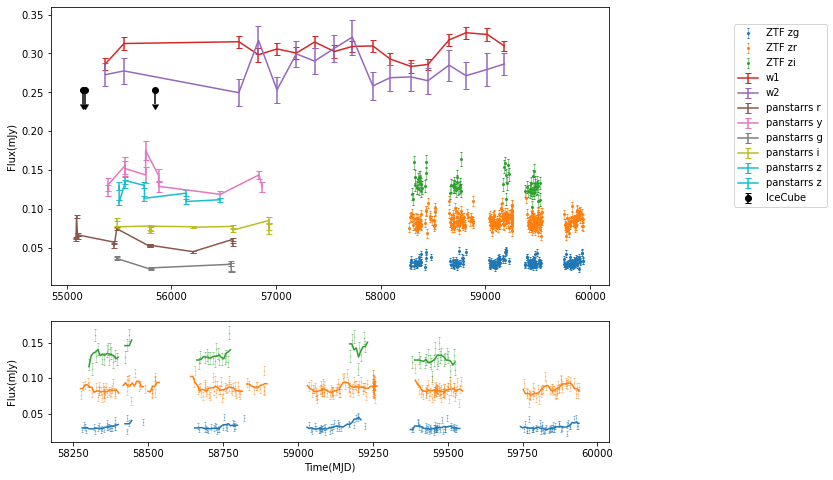

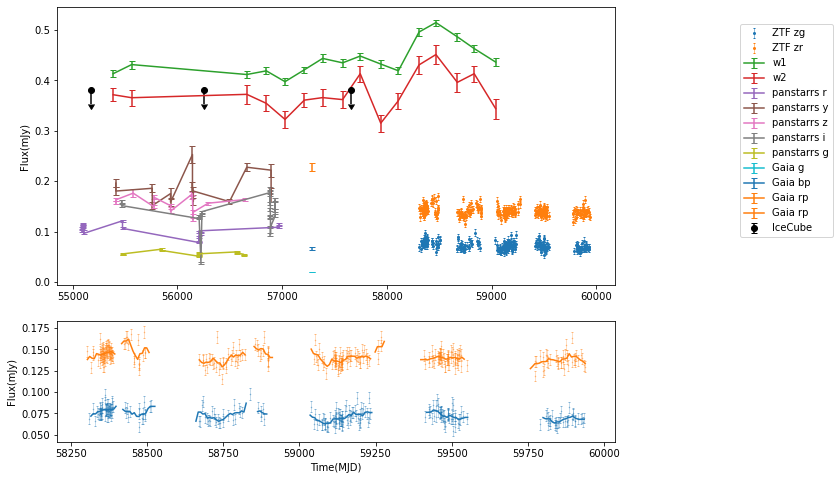

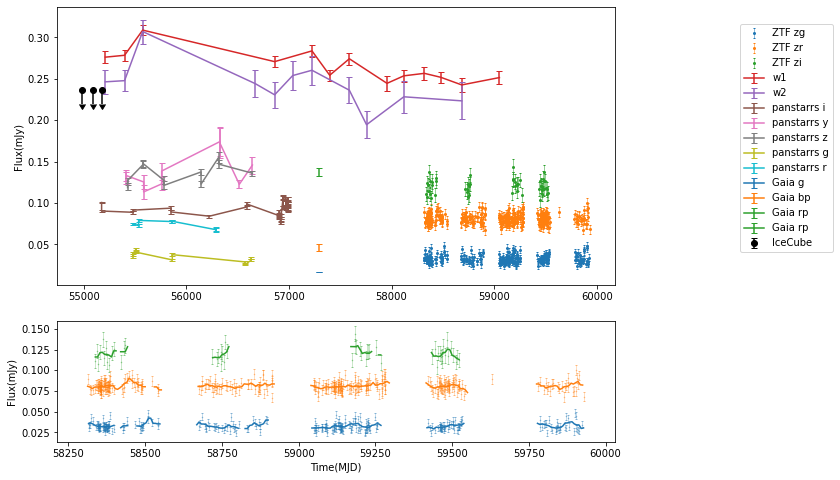

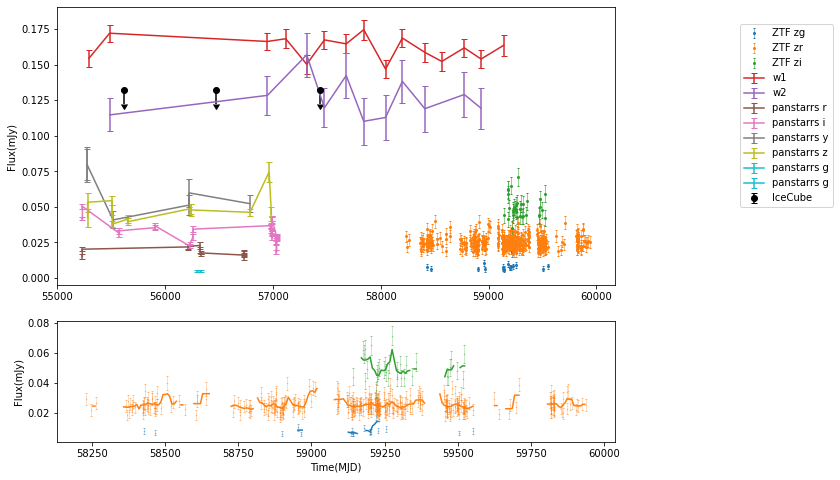

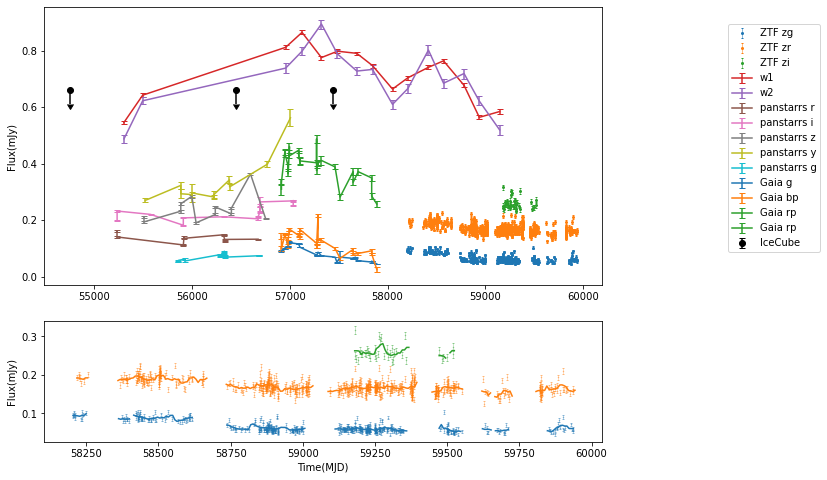

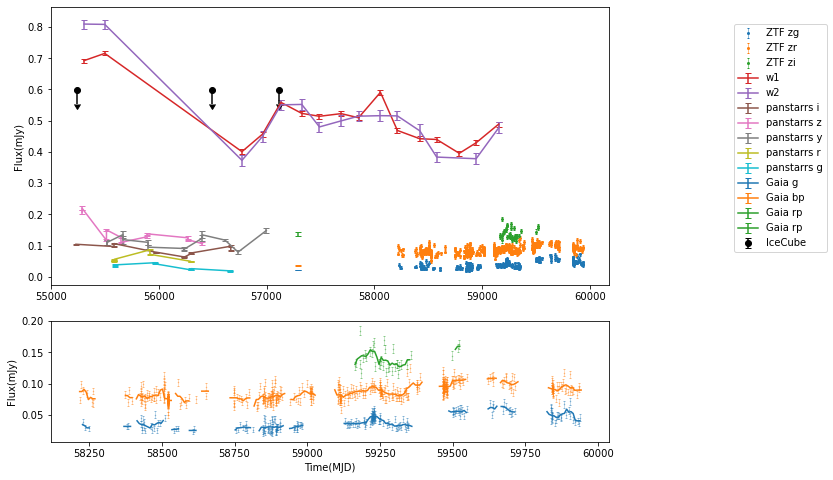

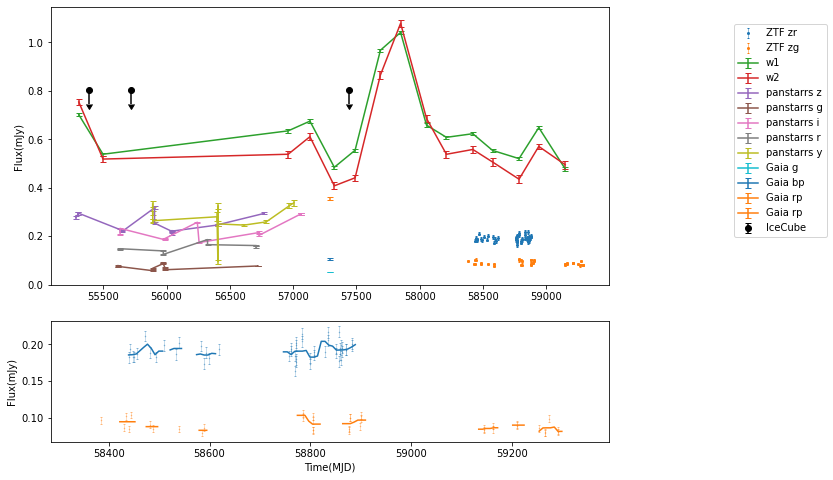

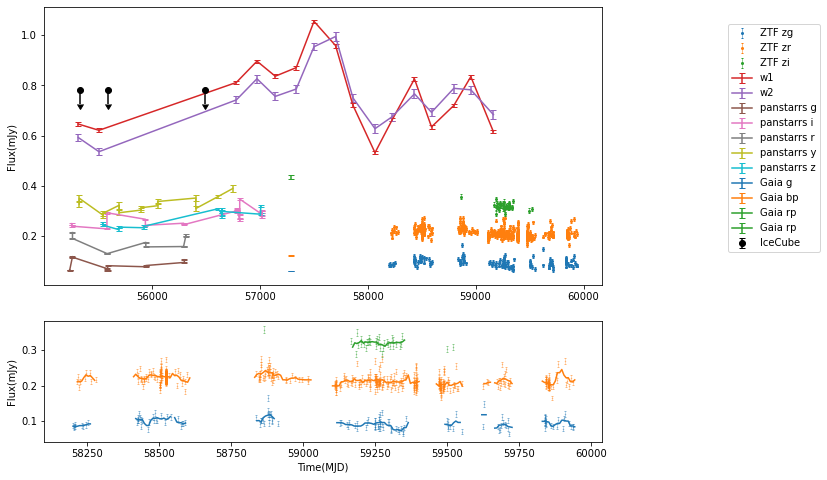

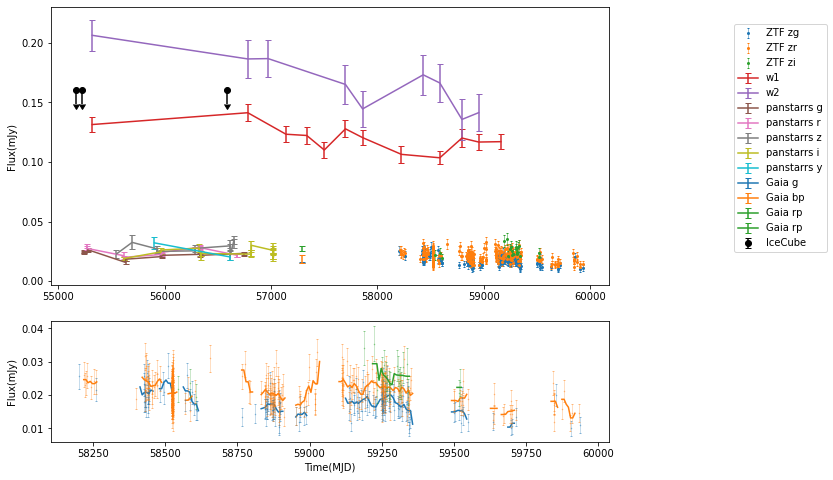

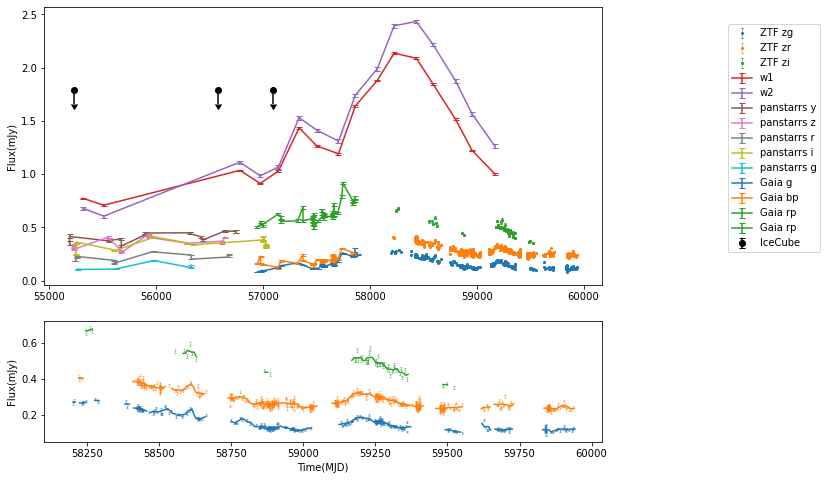

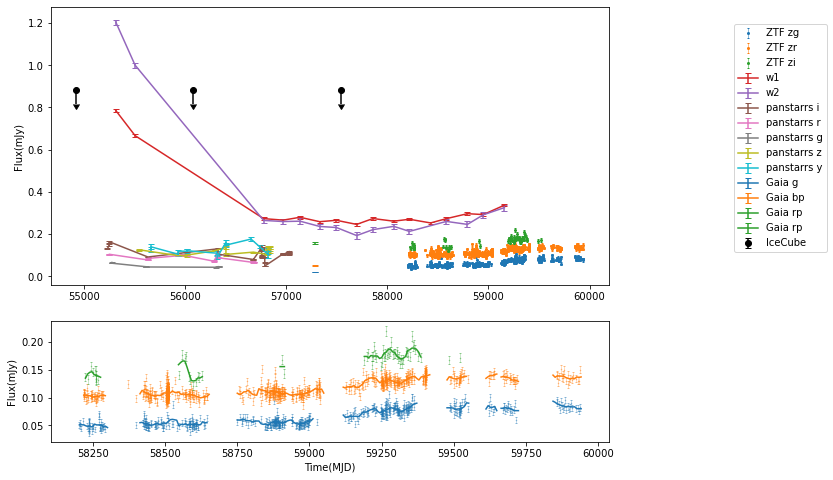

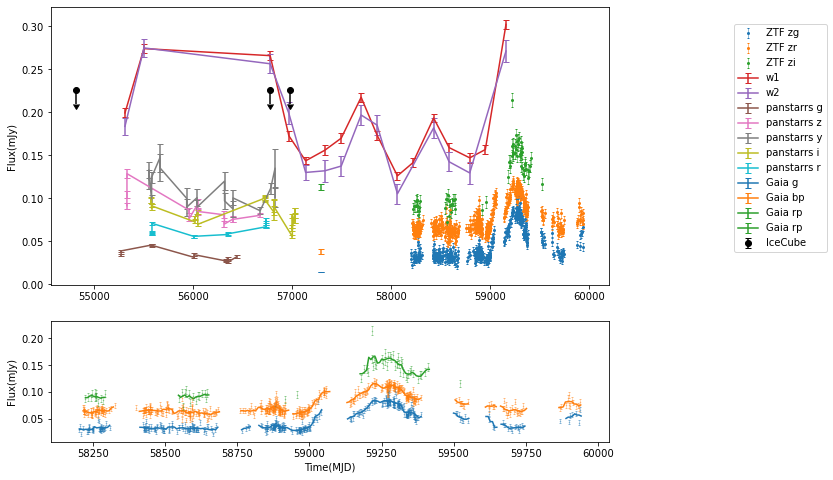

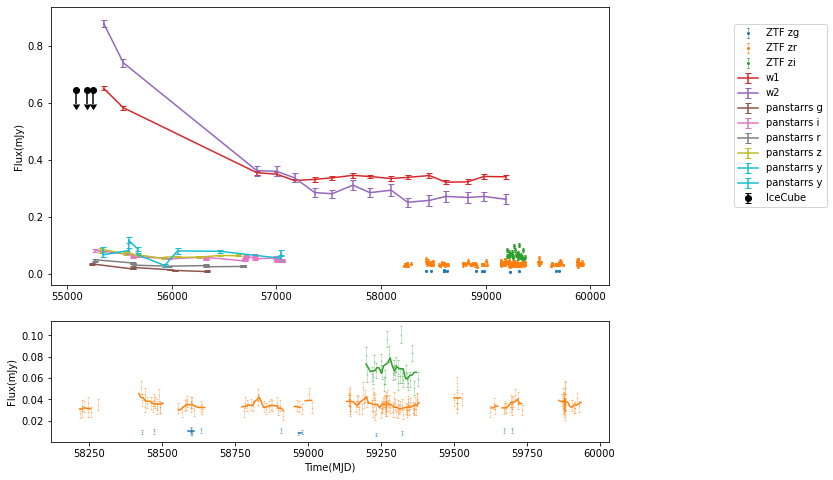

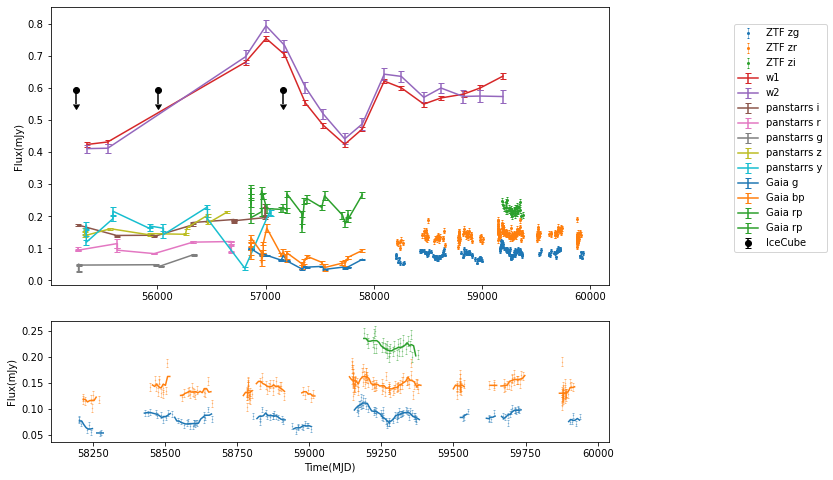

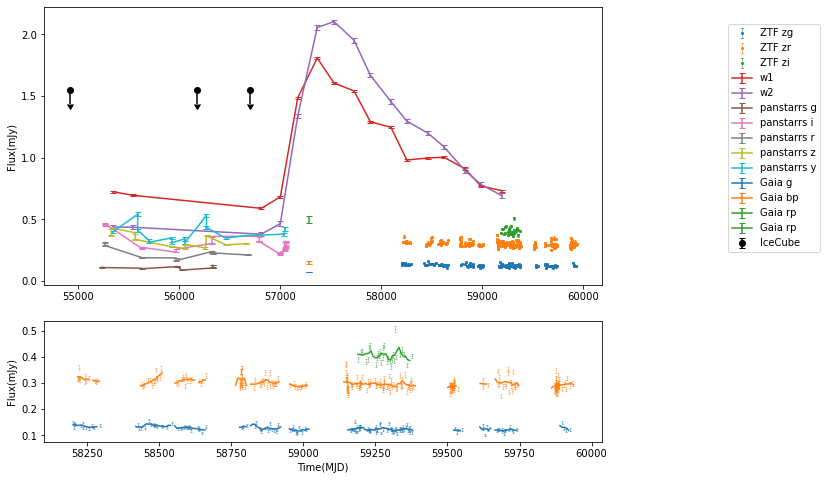

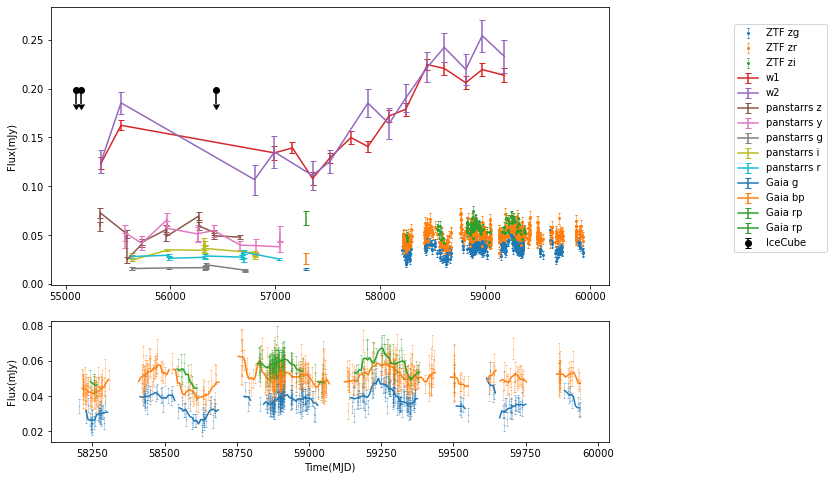

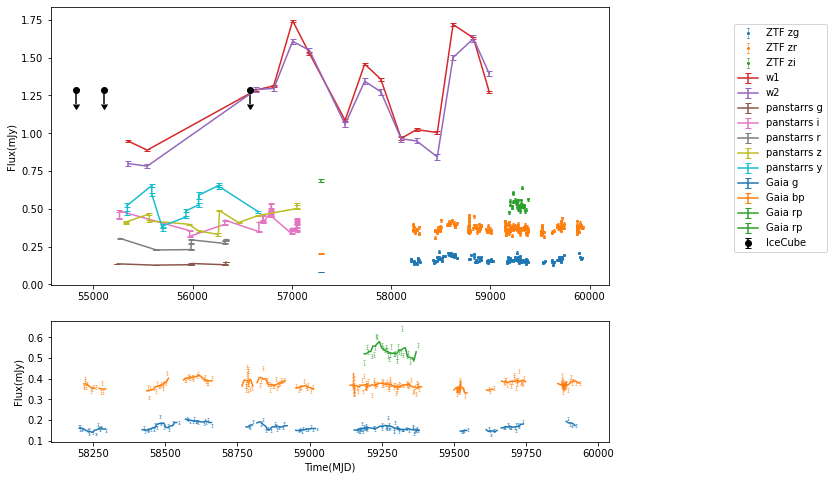

KeyboardInterrupt: 

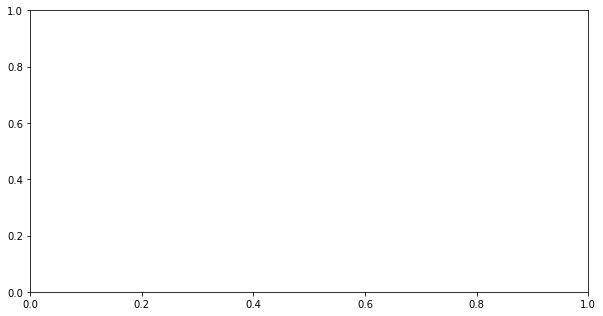

In [20]:
%%time

for objectid, coord in coords_list:
    
    ## Set up =================
    # choose whether to plot data from the serial or parallel calls
    singleobj = df_lc.data.loc[objectid]
    # singleobj = parallel_df_lc.data.loc[objectid]

    # Set up for plotting. We use the "mosaic" method so we can plot
    # the ZTF data in a subplot for better visibility.
    fig, axes = plt.subplot_mosaic(mosaic=[["A"],["A"],["B"]] , figsize=(10,8))
    plt.subplots_adjust(hspace=0.3 , wspace=0.3)

    ## Plot all the bands in the *main plot* (A) ====================
    leg_handles_A = []
    max_list = [] # store maximum flux for each band
    ztf_minmax_tab = Table(names=["tmin","tmax","fluxmin","fluxmax"]) # store the min and max of the ZTF band fluxes and time
    has_ztf = False # flag to set to True if ZTF data is available.
    has_icecube = False # flag to set to True if IceCube data is available.
    
    for band in singleobj.index.unique('band'):
        
        # get data
        band_lc = singleobj.loc[:, band, :]
        band_lc.reset_index(inplace = True)

        # first clean dataframe to remove erroneous rows
        band_lc_clean = band_lc[band_lc['time'] < 65000]
        
        # Do some sigma-clipping, but only if more than 10 data points.
        if len(band_lc_clean) >= 10:
            band_lc_clean = band_lc_clean[np.abs(stats.zscore(band_lc_clean.flux)) < 3.0]
        
        # before plotting need to scale the Kepler, K2, and TESS fluxes to the other available fluxes
        if band in ['Kepler', 'K2', 'TESS']: # Note: these are not included anymore...
            
            #remove outliers in the dataset
            #bandlc_clip = band_lc_clean[(np.abs(stats.zscore(band_lc_clean['flux'])) < 3.0)]

            #find the maximum value of 'other bands'
            max_electrons = max(band_lc_clean.flux)
            factor = np.mean(max_list)/ max_electrons
            lh = axes["A"].errorbar(bandlc_clip.time, bandlc_clip.flux * factor, bandlc_clip.err* factor,
                                    capsize = 3.0,label = band)
            
        # ZTF is special because we are plotting the data also in "B" zoom-in
        elif band in ['zg','zr','zi']: # for ZTF
            has_ztf = True
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5,marker='o',markersize=2,linestyle='', label = "ZTF {}".format(band))
            ztf_minmax_tab.add_row( [np.min(band_lc_clean.time) , np.max(band_lc_clean.time) , np.min(band_lc_clean.flux) , np.max(band_lc_clean.flux) ] )
            
            
            # plot ZTF in zoomin
            p1 = axes["B"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5, marker='o',linestyle='',markersize=0.5, alpha=0.5,
                                    label = "ZTF {}".format(band) , color=lh.lines[0].get_color())
            
            
            
            # overplot running mean fo ZTF in zoomin 
            xx = band_lc_clean.time.values # Note: need to use .values here to remove indexing.
            yy = band_lc_clean.flux.values # Note: need to use .values here to remove indexing.
            ee = band_lc_clean.err.values # Note: need to use .values here to remove indexing.
            x_bin = 30 # in MJD
            x_grid = np.arange(np.nanmin(xx) , np.nanmax(xx)+x_bin/4 , x_bin/4)
            tmp = Table(names=["xbin","ybin","yerr"])
            
            for xxx in x_grid:
                s = np.where( np.abs(xx - xxx) < x_bin/2 )[0]
                if len(s) > 1:
                    mn = np.nansum(yy[s]*ee[s]) / np.nansum(ee[s]) # weighted mean
                    tmp.add_row([xxx , mn , np.nanstd(yy[s])])
                else:
                    tmp.add_row([xxx , np.nan , np.nan])
                    
            axes["B"].plot(tmp["xbin"] , tmp["ybin"] , "-", linewidth=1.5 , color=p1.lines[0].get_color())
            
            
        
        # IceCube is special because it's only events (= limits on plot.)
        elif band in ["IceCube"]:
            has_icecube = True
            # We deal with this later. Need to wait for all the things to plot
            # so we know the y limits.
            
        # Now plot everything else
        else:
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 3.0, label = band)
            
        leg_handles_A.append(lh) # add legend handles
        
    ## Now plot IceCube.
    # we had to wait for all the data to be plotted so we know
    # the y-limits of the resulting final plot. So, we do IceCube
    # at the end.
    if has_icecube:
        band_lc = singleobj.loc[:, "IceCube", :]
        band_lc.reset_index(inplace = True)
        band_lc_clean = band_lc[band_lc['time'] < 65000]
        
        y = axes["A"].get_ylim()[0] + np.diff(axes["A"].get_ylim())*0.7
        dy = np.diff(axes["A"].get_ylim())/20
        lh = axes["A"].errorbar(band_lc_clean.time , np.repeat(y , len(band_lc_clean.time)) , yerr=dy, uplims=True ,
                                fmt="o"  , label="IceCube" , color="black")
    
        leg_handles_A.append(lh) # add legend handles (for IceCube)
    
    
    ## Do Axes ===============
    axes["A"].set_ylabel('Flux(mJy)')
    
    # Plot the ZTF bands in a separate plot to show their variability
    # more clearly. Can still also plot the rest, just change the x and
    # y axis limits. Only do this if ZTF is available for source.
    if has_ztf:
        axes["B"].set_ylabel('Flux(mJy)')
        axes["B"].set_xlabel('Time(MJD)')
        axes["B"].set_xlim( np.min(ztf_minmax_tab["tmin"])-100 , np.max(ztf_minmax_tab["tmax"])+100 )
    
    
    plt.legend(handles=leg_handles_A , bbox_to_anchor=(1.4,3.5))
    plt.tight_layout()
    #save the plot to data/*.pdf
    savename = "data/lightcurve_{}.pdf".format(objectid)
    plt.savefig(savename, bbox_inches="tight")
    plt.show()

## References

This work made use of:

- Astroquery; Ginsburg et al., 2019, 2019AJ....157...98G

- Astropy; Astropy Collaboration 2022, Astropy Collaboration 2018, Astropy Collaboration 2013, 2022ApJ...935..167A, 2018AJ....156..123A, 2013A&A...558A..33A

- Lightkurve; Lightkurve Collaboration 2018, 2018ascl.soft12013L

- acstools; https://zenodo.org/record/7406933#.ZBH1HS-B0eY

- unTimely; Meisner et al., 2023, 2023AJ....165...36M

- Alerce; Forster et al., 2021, 2021AJ....161..242F